In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from catboost import CatBoostClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

### Load Data

In [2]:
df = pd.read_csv("mod_data.csv")
df.head()

Ticker                  Nama Perusahaan Tanggal Listing  \
0   UNIQ               PT Ulima Nitra Tbk        8-Mar-21   
1   GTRA  PT Grahaprima Suksesmandiri Tbk       30-Mar-23   
2   BSBK  PT Wulandari Bangun Laksana Tbk        8-Nov-22   
3   COAL   PT Black Diamond Resources Tbk        7-Sep-22   
4   CRAB    PT Toba Surimi Industries Tbk       10-Aug-22   

                      Sektor  \
0                     Energy   
1  Transportation & Logistic   
2   Properties & Real Estate   
3                     Energy   
4     Consumer Non-Cyclicals   

                                         Underwriter   Papan Pencatatan  \
0                           PT Surya Fajar Sekuritas              utama   
1                          PT UOB Kay Hian Sekuritas       pengembangan   
2  PT KGI Sekuritas Indonesia; PT Panca Global Se...       pengembangan   
3                           PT Surya Fajar Sekuritas  pemantauan khusus   
4                         PT KGI Sekuritas Indonesia       pengembangan   

  Ownership  Listed Share  Persen Saham Ditawarkan  \
0   lainnya  3.138983e+09                   0.0956   
1   lainnya  1.894375e+09                   0.2000   
2   lainnya  2.275000e+10                   0.1209   
3   lainnya  6.250000e+09                   0.2000   
4   lainnya  1.950000e+09                   0.2000   

  Rencana Penggunaan Dana IPO  ... Total Liabilitas    Pendapatan  \
0                 modal kerja  ...     2.670000e+11  2.710000e+11   
1               modal belanja  ...     4.570000e+11  1.950000e+11   
2                 modal kerja  ...     1.120000e+12  5.590600e+10   
3                 modal kerja  ...     2.500000e+14  9.553076e+10   
4                 modal kerja  ...     2.470000e+11  1.360000e+11   

     Laba Kotor  Laba Berjalan (Bukan Komperhensif)  Harga Final  1D %  1W %  \
0  2.454700e+10                       -5.617000e+09          118   999    35   
1  8.756900e+10                        1.130000e+11          150   999    85   
2  3.895000e+10                       -1.943000e+09          100   999   170   
3  4.902891e+10                        4.330173e+10          100   999   280   
4  1.738746e+10                        2.926422e+09          150   999    56   

    1M %  6M %  1Y %  
0    5.0 -25.0 -30.0  
1   77.0  39.0   9.0  
2  140.0 -50.0 -50.0  
3  354.0  36.0 -45.0  
4   59.0  41.0  59.0  

[5 rows x 22 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 22 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Ticker                              223 non-null    object 
 1   Nama Perusahaan                     223 non-null    object 
 2   Tanggal Listing                     223 non-null    object 
 3   Sektor                              223 non-null    object 
 4   Underwriter                         223 non-null    object 
 5   Papan Pencatatan                    223 non-null    object 
 6   Ownership                           223 non-null    object 
 7   Listed Share                        223 non-null    float64
 8   Persen Saham Ditawarkan             223 non-null    float64
 9   Rencana Penggunaan Dana IPO         223 non-null    object 
 10  Valuation Currency                  223 non-null    object 
 11  Total Aset                          223 non-n

### Preprocessing awal + cleaning

In [4]:
cols_to_float = ['Listed Share', 'Total Aset', 'Total Liabilitas', 'Pendapatan', 'Harga Final']
df[cols_to_float] = df[cols_to_float].astype(float)

cols_percent = ['1D %', '1W %', '1M %', '6M %', '1Y %']
df[cols_percent] = df[cols_percent].replace('%', '', regex=True).astype(float)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 22 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Ticker                              223 non-null    object 
 1   Nama Perusahaan                     223 non-null    object 
 2   Tanggal Listing                     223 non-null    object 
 3   Sektor                              223 non-null    object 
 4   Underwriter                         223 non-null    object 
 5   Papan Pencatatan                    223 non-null    object 
 6   Ownership                           223 non-null    object 
 7   Listed Share                        223 non-null    float64
 8   Persen Saham Ditawarkan             223 non-null    float64
 9   Rencana Penggunaan Dana IPO         223 non-null    object 
 10  Valuation Currency                  223 non-null    object 
 11  Total Aset                          223 non-n

In [6]:
df.isna().sum()

Ticker                                 0
Nama Perusahaan                        0
Tanggal Listing                        0
Sektor                                 0
Underwriter                            0
Papan Pencatatan                       0
Ownership                              0
Listed Share                           0
Persen Saham Ditawarkan                0
Rencana Penggunaan Dana IPO            0
Valuation Currency                     0
Total Aset                             0
Total Liabilitas                       0
Pendapatan                             0
Laba Kotor                             0
Laba Berjalan (Bukan Komperhensif)     0
Harga Final                            0
1D %                                   0
1W %                                   0
1M %                                   2
6M %                                  18
1Y %                                  30
dtype: int64

In [7]:
column_to_impute = ['Pendapatan', 'Laba Kotor', 'Laba Berjalan (Bukan Komperhensif)']
data_to_impute = df[column_to_impute].values
imputer = IterativeImputer(max_iter=10, random_state=0)
imputed_data = imputer.fit_transform(data_to_impute)
df[column_to_impute] = imputed_data
print("\nMissing values after imputation:")
print(df.isna().sum())



Missing values after imputation:
Ticker                                 0
Nama Perusahaan                        0
Tanggal Listing                        0
Sektor                                 0
Underwriter                            0
Papan Pencatatan                       0
Ownership                              0
Listed Share                           0
Persen Saham Ditawarkan                0
Rencana Penggunaan Dana IPO            0
Valuation Currency                     0
Total Aset                             0
Total Liabilitas                       0
Pendapatan                             0
Laba Kotor                             0
Laba Berjalan (Bukan Komperhensif)     0
Harga Final                            0
1D %                                   0
1W %                                   0
1M %                                   2
6M %                                  18
1Y %                                  30
dtype: int64


### Feature Engineering

#### Target columns

In [8]:
'''
note ARA:
Below IDR 200	+35%
IDR 200 to below IDR 5,000	+25%
IDR 5,000 and above	+20%

list ARA D1:
UNIQ -> ACRO
MORA -> OILS
AADI
MCOL -> HAJJ excl. VTNY SICO IKPM
RUNS

dataset updated = D1 % 999 -> ARA
'''


'\nnote ARA:\nBelow IDR 200\t+35%\nIDR 200 to below IDR 5,000\t+25%\nIDR 5,000 and above\t+20%\n\nlist ARA D1:\nUNIQ -> ACRO\nMORA -> OILS\nAADI\nMCOL -> HAJJ excl. VTNY SICO IKPM\nRUNS\n\ndataset updated = D1 % 999 -> ARA\n'

In [9]:
df['1D %'] = df['1D %'].apply(lambda x: 'ARA' if x == 999 else ('plus' if x >= 0 else 'minus'))

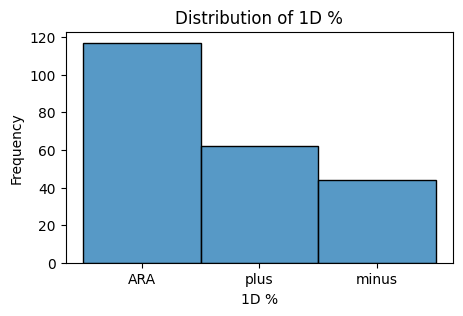

In [10]:
plt.figure(figsize=(5, 3))
sns.histplot(df['1D %'])
plt.title('Distribution of 1D %')
plt.xlabel('1D %')
plt.ylabel('Frequency')
plt.show()

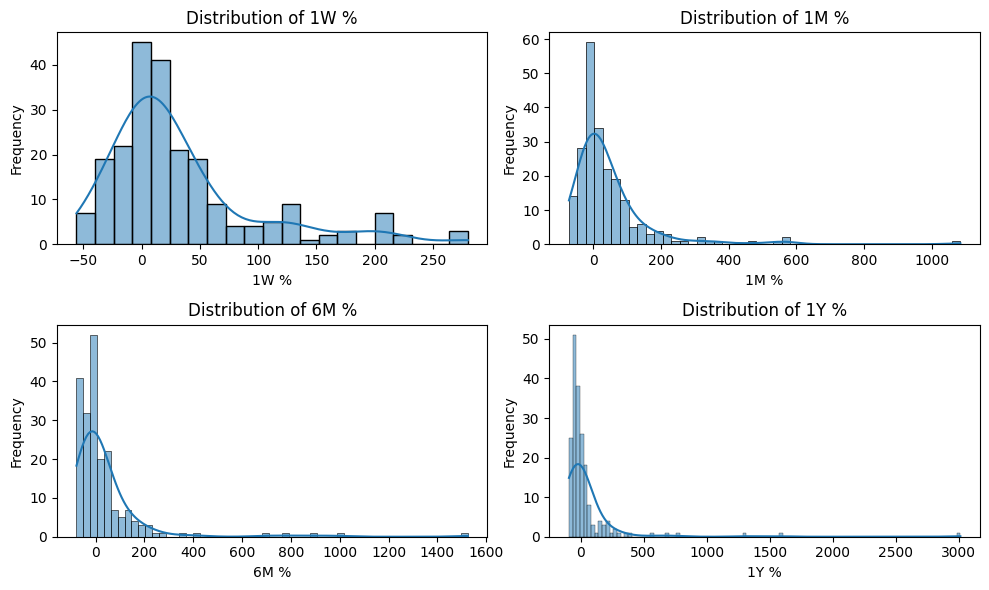

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
cols = ['1W %', '1M %', '6M %', '1Y %']
titles = ['Distribution of 1W %', 'Distribution of 1M %', 'Distribution of 6M %', 'Distribution of 1Y %']

for ax, col, title in zip(axes.flat, cols, titles):
    sns.histplot(df[col].dropna(), ax=ax, kde=True)
    ax.set_title(title)
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [12]:
df[['1D %', '1W %', '1M %', '6M %', '1Y %']].describe()

1W %         1M %         6M %         1Y %
count  223.000000   221.000000   205.000000   193.000000
mean    33.600897    46.339367    36.365854    43.761658
std     65.820582   123.192266   174.078999   285.472553
min    -56.000000   -72.000000   -78.000000   -92.000000
25%     -4.000000   -11.000000   -41.000000   -50.000000
50%     13.000000    10.000000    -7.000000   -22.000000
75%     46.500000    66.000000    42.000000    35.000000
max    280.000000  1085.000000  1525.000000  3014.000000

In [13]:
def categorize_mid(val):
    if pd.isnull(val):
        return val
    return 'good' if val >= 5 else 'bad'

def categorize_long(val):
    if pd.isnull(val):
        return val
    elif val >= 0:
        return 'plus'
    else:
        return 'minus'
    
for col in ['1W %', '1M %']:
    df[col] = df[col].apply(categorize_mid)
for col in ['6M %', '1Y %']:
    df[col] = df[col].apply(categorize_long)

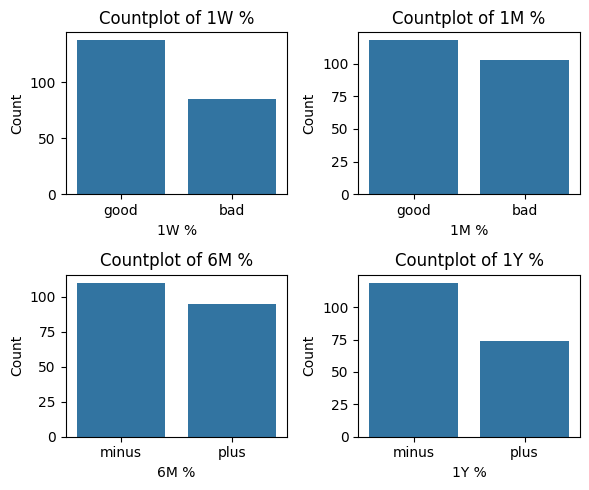

In [14]:
plt.figure(figsize=(6, 5))
for i, col in enumerate(['1W %', '1M %', '6M %', '1Y %'], 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=df[col])
    plt.title(f'Countplot of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [15]:
df['Tanggal Listing'] = pd.to_datetime(df['Tanggal Listing'], format='%d-%b-%y', errors='coerce')
df.sort_values('Tanggal Listing', inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

Ticker                Nama Perusahaan Tanggal Listing           Sektor  \
0   UNIQ             PT Ulima Nitra Tbk      2021-03-08           Energy   
1   ARCI         PT Archi Indonesia Tbk      2021-06-28  Basic Materials   
2   MASB  PT Bank Multiarta Sentosa Tbk      2021-06-30       Financials   
3   BMHS              PT Bundamedik Tbk      2021-07-06       Healthcare   
4   UVCR  PT Trimegah Karya Pratama Tbk      2021-07-27       Technology   

                                         Underwriter   Papan Pencatatan  \
0                           PT Surya Fajar Sekuritas              utama   
1  PT BNI Sekuritas; PT Mandiri Sekuritas; PT Cit...       pengembangan   
2                                   PT BCA Sekuritas  pemantauan khusus   
3                        PT Ciptadana Sekuritas Asia              utama   
4  PT Surya Fajar Sekuritas; PT Mirae Asset Sekur...       pengembangan   

     Ownership  Listed Share  Persen Saham Ditawarkan  \
0      lainnya  3.138983e+09                   0.0956   
1  konglomerat  2.483500e+10                   0.1500   
2      lainnya  1.226903e+09                   0.1500   
3  konglomerat  8.603416e+09                   0.0726   
4      lainnya  2.000000e+09                   0.2500   

  Rencana Penggunaan Dana IPO  ... Total Liabilitas    Pendapatan  \
0                 modal kerja  ...     2.670000e+11  2.710000e+11   
1                bayar hutang  ...     6.860000e+12  4.960000e+12   
2                 modal kerja  ...     1.960000e+13  1.210000e+12   
3                bayar hutang  ...     1.110000e+12  1.150000e+12   
4               modal belanja  ...     1.435880e+10  1.940000e+11   

     Laba Kotor  Laba Berjalan (Bukan Komperhensif)  Harga Final  1D %  1W %  \
0  2.454700e+10                       -5.617000e+09        118.0   ARA  good   
1  2.710000e+12                        1.490000e+12        750.0  plus   bad   
2  4.310000e+11                        1.080000e+11       3360.0   ARA   bad   
3  3.680000e+11                        1.180000e+11        340.0   ARA  good   
4  4.634337e+09                        5.434916e+08        100.0   ARA  good   

   1M %   6M %   1Y %  
0  good  minus  minus  
1   bad  minus  minus  
2   bad   plus   plus  
3  good   plus   plus  
4  good   plus   plus  

[5 rows x 22 columns]

#### Underwriter

##### Part 1

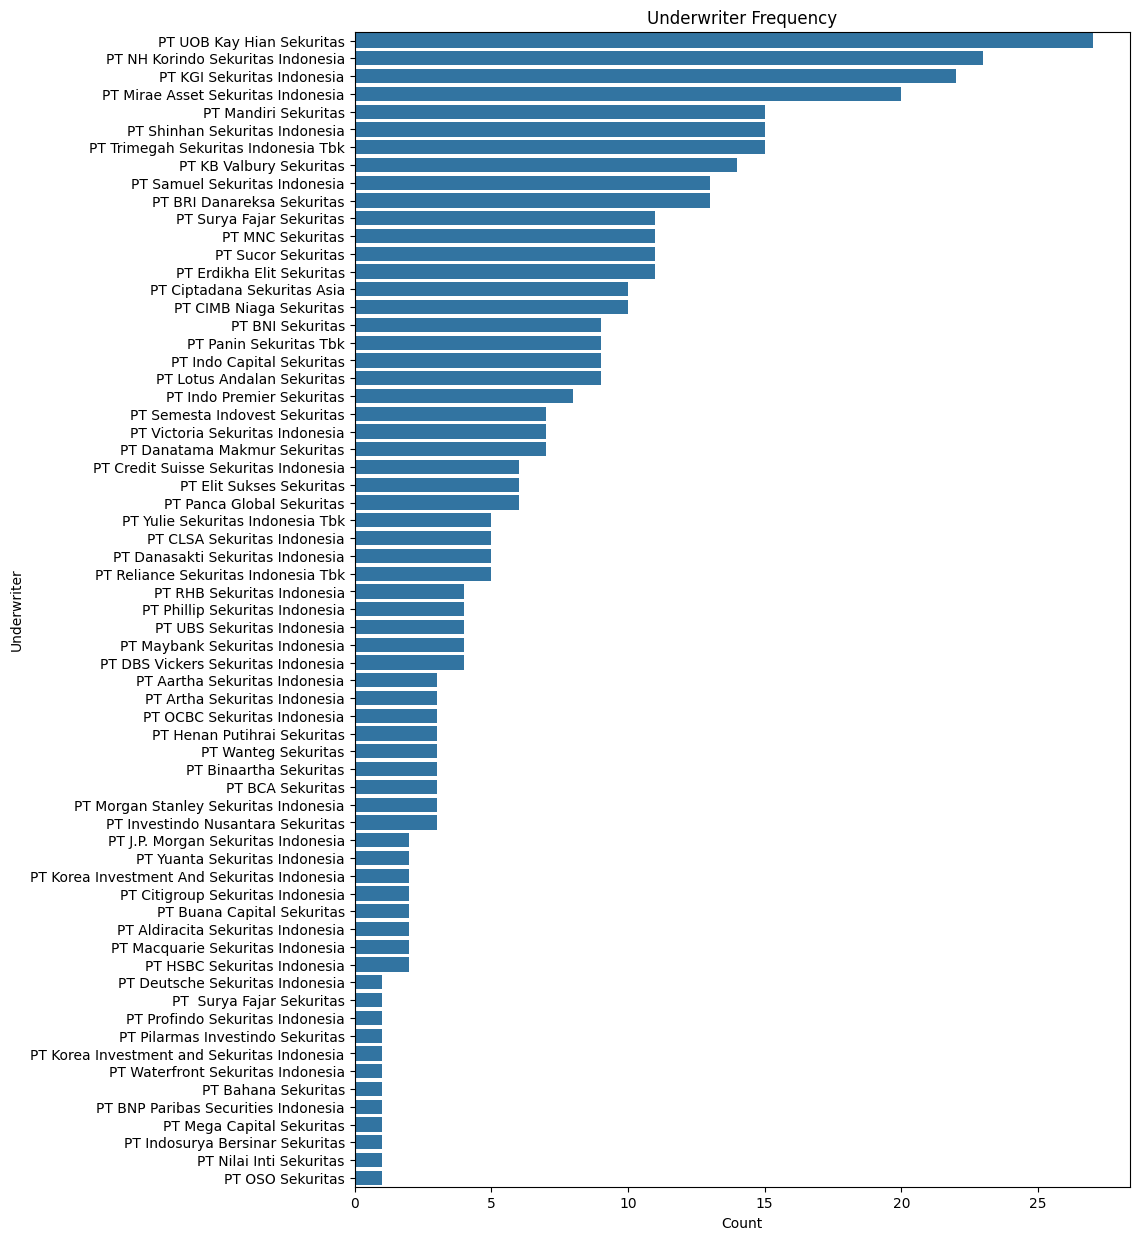

In [16]:
underwriters_exploded = df['Underwriter'].str.split(';').explode().str.strip()
plt.figure(figsize=(10, 15))
sns.countplot(y=underwriters_exploded, order=underwriters_exploded.value_counts().index)
plt.ylabel('Underwriter')
plt.xlabel('Count')
plt.title('Underwriter Frequency')
plt.show()


In [17]:
freq_dict = {}
aset_dict = {}
jumlah_dict = {}

for idx, row in df.iterrows():
    underwriters = [uw.strip() for uw in row['Underwriter'].split(';') if uw.strip()]
    persen = row['Persen Saham Ditawarkan']
    listed_share = row['Listed Share']
    harga_final = row['Harga Final']
    total_aset = row['Total Aset']
    
    jumlah = listed_share * harga_final * persen
    for uw in underwriters:
        freq_dict[uw] = freq_dict.get(uw, 0) + 1
        aset_dict[uw] = aset_dict.get(uw, 0.0) + total_aset
        jumlah_dict[uw] = jumlah_dict.get(uw, 0.0) + jumlah

uw_stats = []
for uw in freq_dict:
    freq = freq_dict[uw]
    avg_aset = aset_dict[uw] / freq if freq else 0
    avg_jumlah = jumlah_dict[uw] / freq if freq else 0
    uw_stats.append((uw, freq, avg_aset, avg_jumlah))

uw_df = pd.DataFrame(uw_stats, columns=['underwriter', 'freq', 'avg_aset', 'avg_jumlah']).reset_index(drop=True)
uw_df.head()

underwriter  freq      avg_aset    avg_jumlah
0              PT Surya Fajar Sekuritas    11  1.894937e+11  1.059479e+11
1                      PT BNI Sekuritas     9  3.898356e+13  4.461379e+12
2                  PT Mandiri Sekuritas    15  2.824633e+13  6.182559e+12
3      PT Citigroup Sekuritas Indonesia     2  2.134000e+13  6.393589e+12
4  PT Credit Suisse Sekuritas Indonesia     6  4.180333e+13  8.209206e+12

In [18]:
high_aset = uw_df['avg_aset'].quantile(0.75)
low_aset = uw_df['avg_aset'].quantile(0.25)

def aset_category(val):
    if val >= high_aset:
        return 'high'
    elif val <= low_aset:
        return 'low'
    else:
        return 'mid'

uw_df['avg_aset_category'] = uw_df['avg_aset'].apply(aset_category)

high_freq = uw_df['freq'].quantile(0.75)
low_freq = uw_df['freq'].quantile(0.25)

def freq_category(val):
    if val >= high_freq:
        return 'high'
    elif val <= low_freq:
        return 'low'
    else:
        return 'mid'

uw_df['freq_category'] = uw_df['freq'].apply(freq_category)
uw_df.head()

underwriter  freq      avg_aset    avg_jumlah  \
0              PT Surya Fajar Sekuritas    11  1.894937e+11  1.059479e+11   
1                      PT BNI Sekuritas     9  3.898356e+13  4.461379e+12   
2                  PT Mandiri Sekuritas    15  2.824633e+13  6.182559e+12   
3      PT Citigroup Sekuritas Indonesia     2  2.134000e+13  6.393589e+12   
4  PT Credit Suisse Sekuritas Indonesia     6  4.180333e+13  8.209206e+12   

  avg_aset_category freq_category  
0               low          high  
1              high          high  
2              high          high  
3              high           low  
4              high           mid

In [19]:
#uw_df.to_csv('uw_df.csv', index=False)

In [20]:
df['lead_underwriter'] = df['Underwriter'].str.split(';').str[0].str.strip()

In [21]:
uw_map_freq_cat = uw_df.set_index('underwriter')['freq_category'].to_dict()
uw_map_aset_cat = uw_df.set_index('underwriter')['avg_aset_category'].to_dict()

df['underwriter_freq_category'] = df['lead_underwriter'].map(uw_map_freq_cat)
df['underwriter_avg_aset_category'] = df['lead_underwriter'].map(uw_map_aset_cat)

In [22]:
cols = list(df.columns)
last3 = cols[-3:]

idx = cols.index('Nama Perusahaan')
for col in last3:
    cols.remove(col)
for i, col in enumerate(last3):
    cols.insert(idx + 1 + i, col)

df = df[cols]

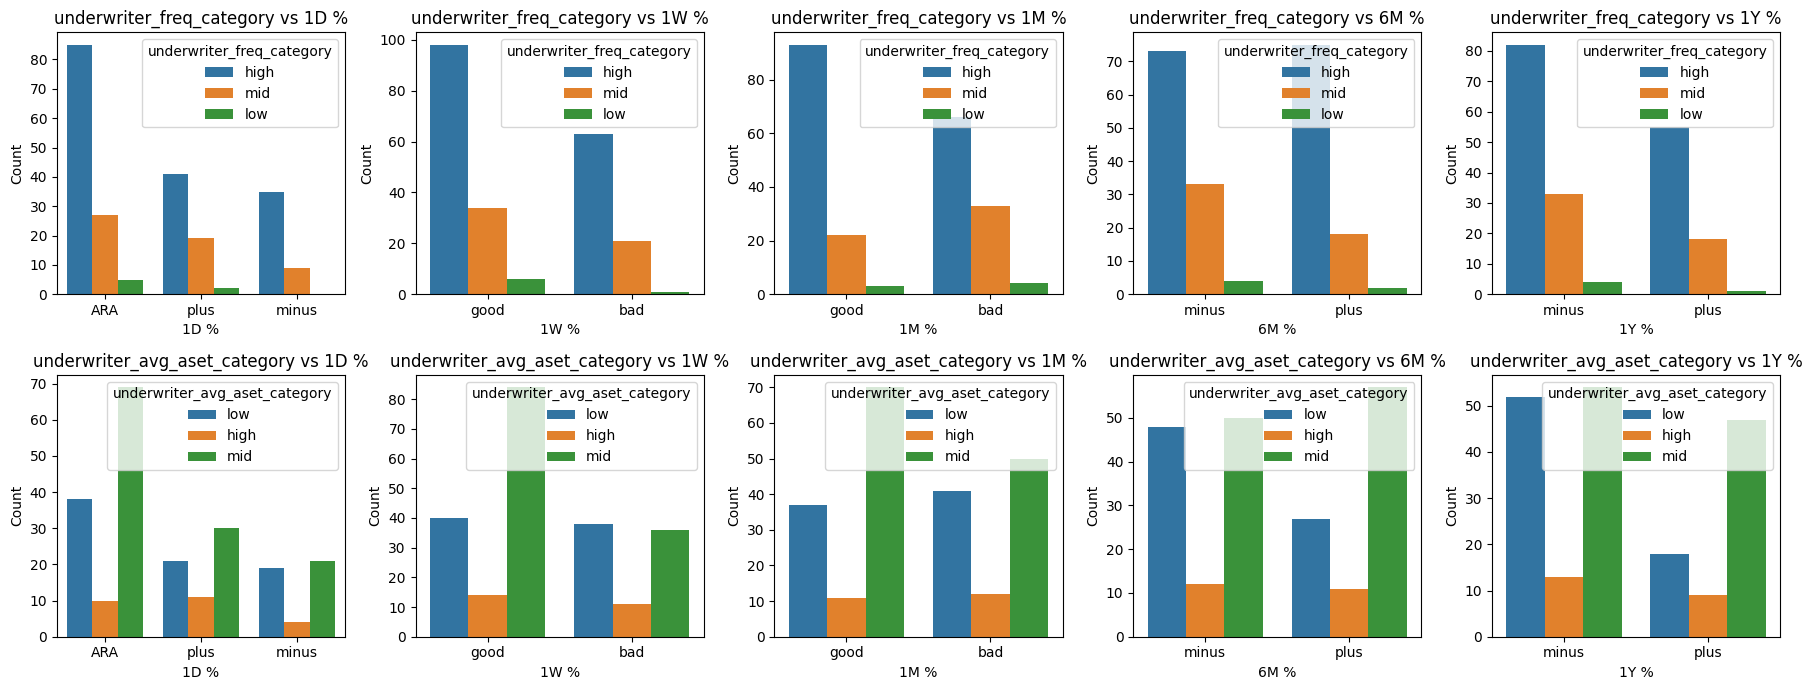

In [23]:
fig, axes = plt.subplots(2, 5, figsize=(18, 7))
target_cols = ['1D %', '1W %', '1M %', '6M %', '1Y %']
plot_cols = ['underwriter_freq_category', 'underwriter_avg_aset_category']

for i, col in enumerate(plot_cols):
    for j, target in enumerate(target_cols):
        ax = axes[i, j]
        sns.countplot(x=df[target], hue=df[col], ax=ax)
        ax.set_title(f"{col} vs {target}")
        ax.set_xlabel(target)
        ax.set_ylabel('Count')
        ax.legend(title=col, loc='best')

plt.tight_layout()
plt.show()

##### Part 2

In [24]:
weights_1d = {'minus': 0.33, 'plus': 0.67, 'ARA': 1}
weights_1w_1m = {'bad': 0.5, 'good': 1}
weights_rest = {'minus': 0.5, 'plus': 1}

df_sorted = df.sort_values('Tanggal Listing').reset_index(drop=True)

for col in ['1D %', '1W %', '1M %', '6M %', '1Y %']:
    if col == '1D %':
        weights = weights_1d
    elif col in ['1W %', '1M %']:
        weights = weights_1w_1m
    else:
        weights = weights_rest

    last3_dict = {}
    avg_last3_col = []
    for _, row in df_sorted.iterrows():
        underwriters = [uw.strip() for uw in row['Underwriter'].split(';') if uw.strip()]
        last3s = []
        for uw in underwriters:
            last3s.extend(last3_dict.get(uw, []))
        if last3s:
            avg_last3_col.append(np.mean([weights[v] for v in last3s if v in weights]))
        else:
            avg_last3_col.append(np.nan)

        val = row[col]
        if pd.notnull(val) and val in weights:
            for uw in underwriters:
                last3 = last3_dict.get(uw, [])
                last3.append(val)
                if len(last3) > 3:
                    last3 = last3[-3:]
                last3_dict[uw] = last3
    df_sorted[f'avg_last3_weighted_{col.replace(" ", "").replace("%", "pct").lower()}'] = avg_last3_col


In [25]:
df_sorted.head(3)

Ticker                Nama Perusahaan          lead_underwriter  \
0   UNIQ             PT Ulima Nitra Tbk  PT Surya Fajar Sekuritas   
1   ARCI         PT Archi Indonesia Tbk          PT BNI Sekuritas   
2   MASB  PT Bank Multiarta Sentosa Tbk          PT BCA Sekuritas   

  underwriter_freq_category underwriter_avg_aset_category Tanggal Listing  \
0                      high                           low      2021-03-08   
1                      high                          high      2021-06-28   
2                       mid                           mid      2021-06-30   

            Sektor                                        Underwriter  \
0           Energy                           PT Surya Fajar Sekuritas   
1  Basic Materials  PT BNI Sekuritas; PT Mandiri Sekuritas; PT Cit...   
2       Financials                                   PT BCA Sekuritas   

    Papan Pencatatan    Ownership  ...  1D %  1W %  1M %   6M %   1Y %  \
0              utama      lainnya  ...   ARA  good  good  minus  minus   
1       pengembangan  konglomerat  ...  plus   bad   bad  minus  minus   
2  pemantauan khusus      lainnya  ...   ARA   bad   bad   plus   plus   

   avg_last3_weighted_1dpct  avg_last3_weighted_1wpct  \
0                       NaN                       NaN   
1                       NaN                       NaN   
2                       NaN                       NaN   

   avg_last3_weighted_1mpct  avg_last3_weighted_6mpct  \
0                       NaN                       NaN   
1                       NaN                       NaN   
2                       NaN                       NaN   

   avg_last3_weighted_1ypct  
0                       NaN  
1                       NaN  
2                       NaN  

[3 rows x 30 columns]

In [26]:
df = df_sorted.copy()
df = df.drop(columns=['Underwriter'])

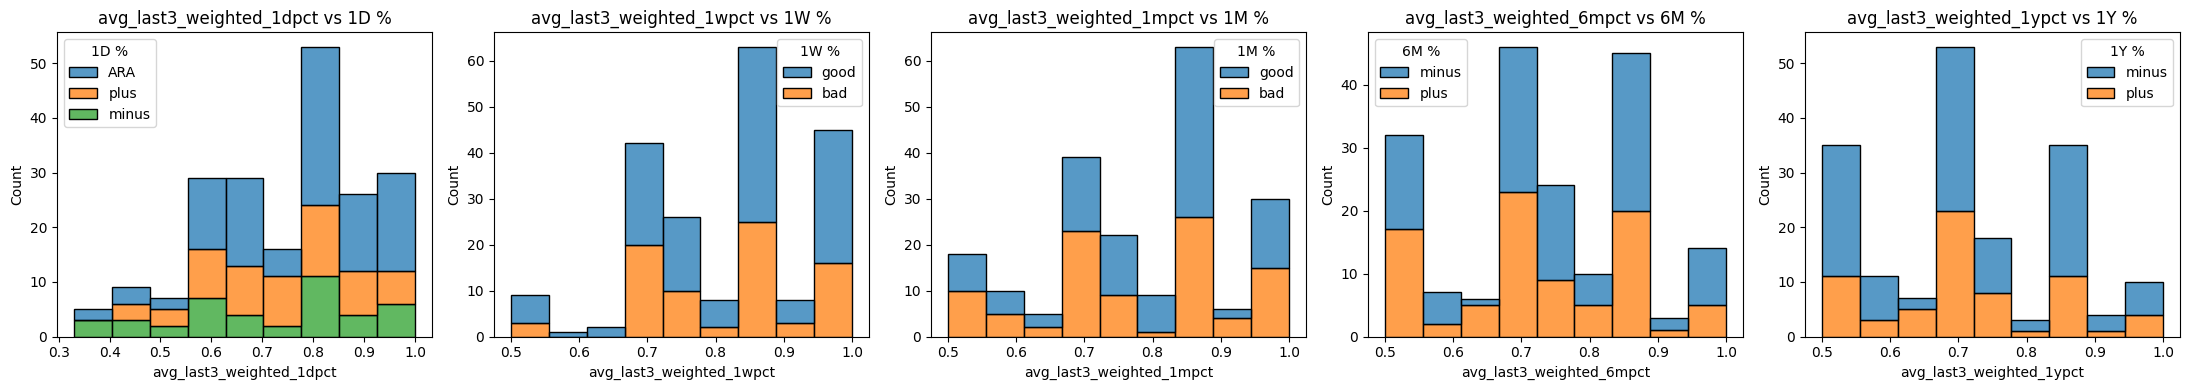

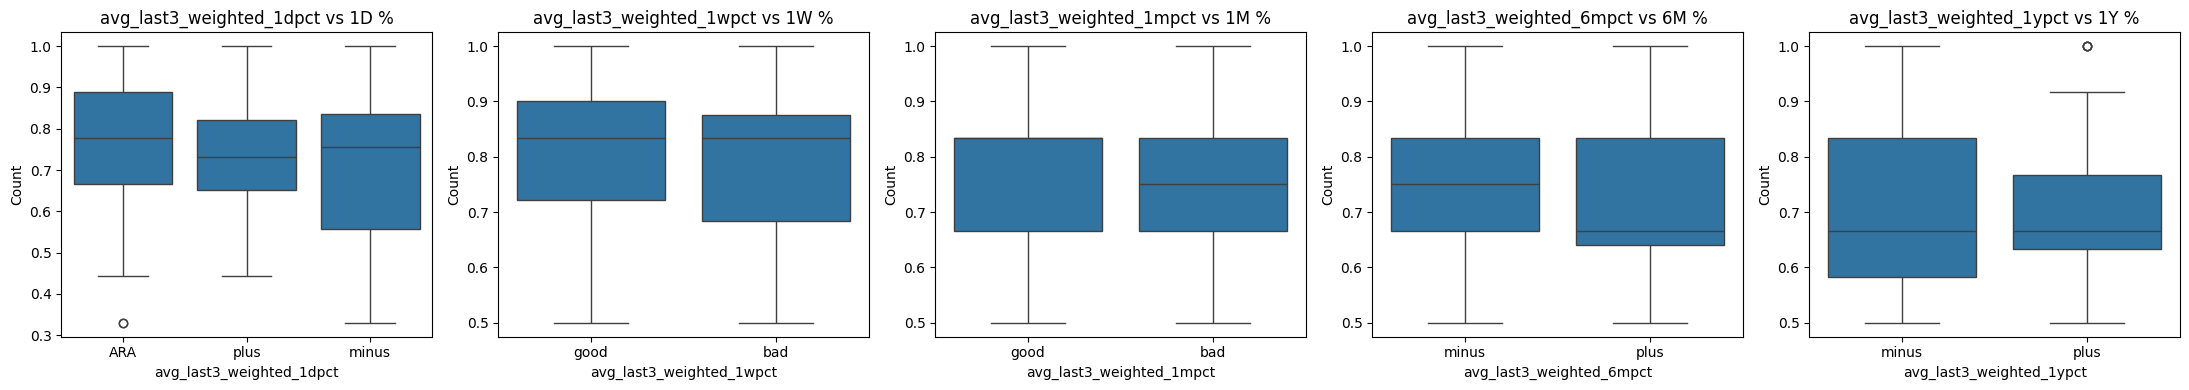

In [48]:
fig, axes = plt.subplots(1, 5, figsize=(22, 4))
plot_pairs = [
    ('avg_last3_weighted_1dpct', '1D %'),
    ('avg_last3_weighted_1wpct', '1W %'),
    ('avg_last3_weighted_1mpct', '1M %'),
    ('avg_last3_weighted_6mpct', '6M %'),
    ('avg_last3_weighted_1ypct', '1Y %'),
]

for i, (x_col, y_col) in enumerate(plot_pairs):
    sns.histplot(data=df_sorted, x=x_col, hue=y_col, multiple="stack", ax=axes[i], kde=False)
    axes[i].set_title(f'{x_col} vs {y_col}')
    axes[i].set_xlabel(x_col)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(22, 4))
for i, (x_col, y_col) in enumerate(plot_pairs):
    sns.boxplot(data=df_sorted, x=y_col, y=x_col, ax=axes[i])
    axes[i].set_title(f'{x_col} vs {y_col}')
    axes[i].set_xlabel(x_col)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

#### VIX

In [27]:
vix_df = pd.read_csv('vix-daily.csv')
vix_df['DATE'] = pd.to_datetime(vix_df['DATE'])
df['Tanggal Listing'] = pd.to_datetime(df['Tanggal Listing'], format='%d-%b-%y', errors='coerce')
vix_df = vix_df.rename(columns={'CLOSE': 'vix'})
df = df.merge(vix_df[['DATE', 'vix']], left_on='Tanggal Listing', right_on='DATE', how='left')
df = df.drop(columns=['DATE'], errors='ignore')
df.head(1)


Ticker     Nama Perusahaan          lead_underwriter  \
0   UNIQ  PT Ulima Nitra Tbk  PT Surya Fajar Sekuritas   

  underwriter_freq_category underwriter_avg_aset_category Tanggal Listing  \
0                      high                           low      2021-03-08   

   Sektor Papan Pencatatan Ownership  Listed Share  ...  1W %  1M %   6M %  \
0  Energy            utama   lainnya  3.138983e+09  ...  good  good  minus   

    1Y %  avg_last3_weighted_1dpct  avg_last3_weighted_1wpct  \
0  minus                       NaN                       NaN   

   avg_last3_weighted_1mpct  avg_last3_weighted_6mpct  \
0                       NaN                       NaN   

   avg_last3_weighted_1ypct    vix  
0                       NaN  25.47  

[1 rows x 30 columns]

In [28]:
def categorize_vix(val):
    if pd.isnull(val):
        return val
    elif val < 15:
        return 'low'
    elif val < 25:
        return 'mid'
    else:
        return 'high'

df['vix_category'] = df['vix'].apply(categorize_vix)
df['vix_category'].value_counts()

vix_category
mid     142
low      46
high     31
Name: count, dtype: int64

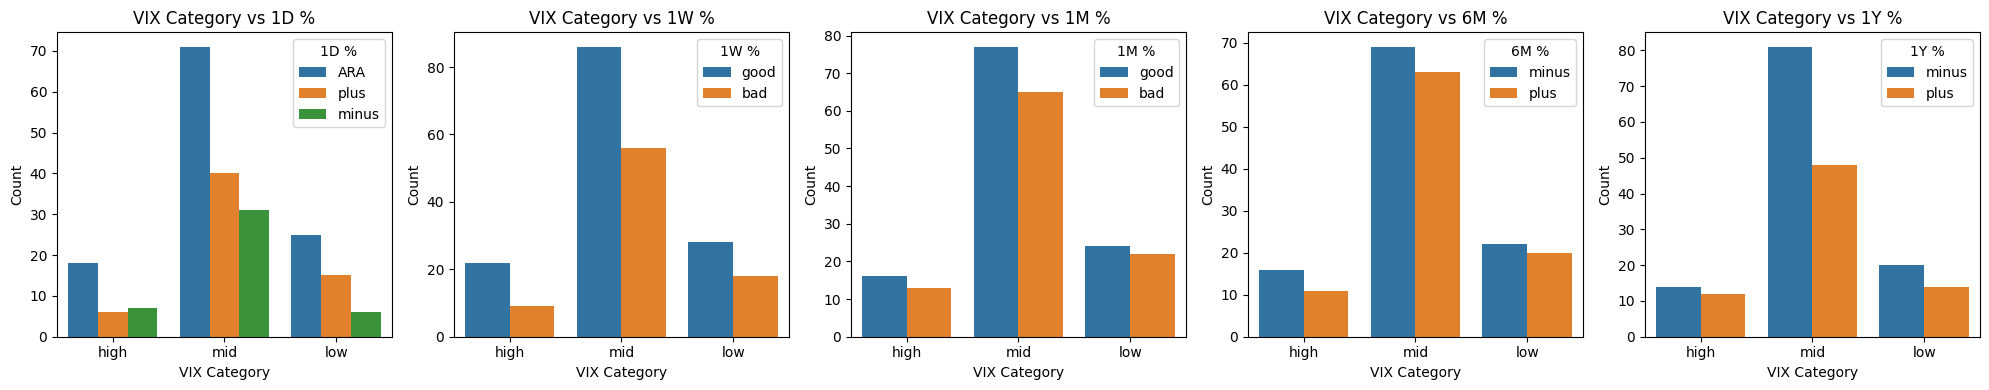

In [29]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, col in enumerate(['1D %', '1W %', '1M %', '6M %', '1Y %']):
    sns.countplot(x=df['vix_category'], hue=df[col], ax=axes[i])
    axes[i].set_title(f'VIX Category vs {col}')
    axes[i].set_xlabel('VIX Category')
    axes[i].set_ylabel('Count')
    axes[i].legend(title=col, loc='best')
plt.tight_layout()
plt.show()

In [32]:
# sepertinya tidak guna

# ->> kondisi market atau ekonomi dunia tidak terlihat mempengaruhi kinerja saham IPO di Indonesia

In [30]:
df = df.drop(columns=['vix', 'vix_category'])

#### Seasonality

In [31]:
def month_to_season(month):
    if month in [12, 1, 2]:
        return 'Rainy'
    elif month in [3, 4, 5]:
        return 'Dry Early'
    elif month in [6, 7, 8]:
        return 'Dry Peak'
    elif month in [9, 10, 11]:
        return 'Dry Late'
    else:
        return 'Unknown'

df['Listing Month'] = df['Tanggal Listing'].dt.month
df['Listing Season'] = df['Listing Month'].apply(month_to_season)
df = df.drop(columns=['Listing Month', 'Tanggal Listing'])
df['Listing Season'].value_counts()


Listing Season
Rainy        74
Dry Peak     60
Dry Late     45
Dry Early    44
Name: count, dtype: int64

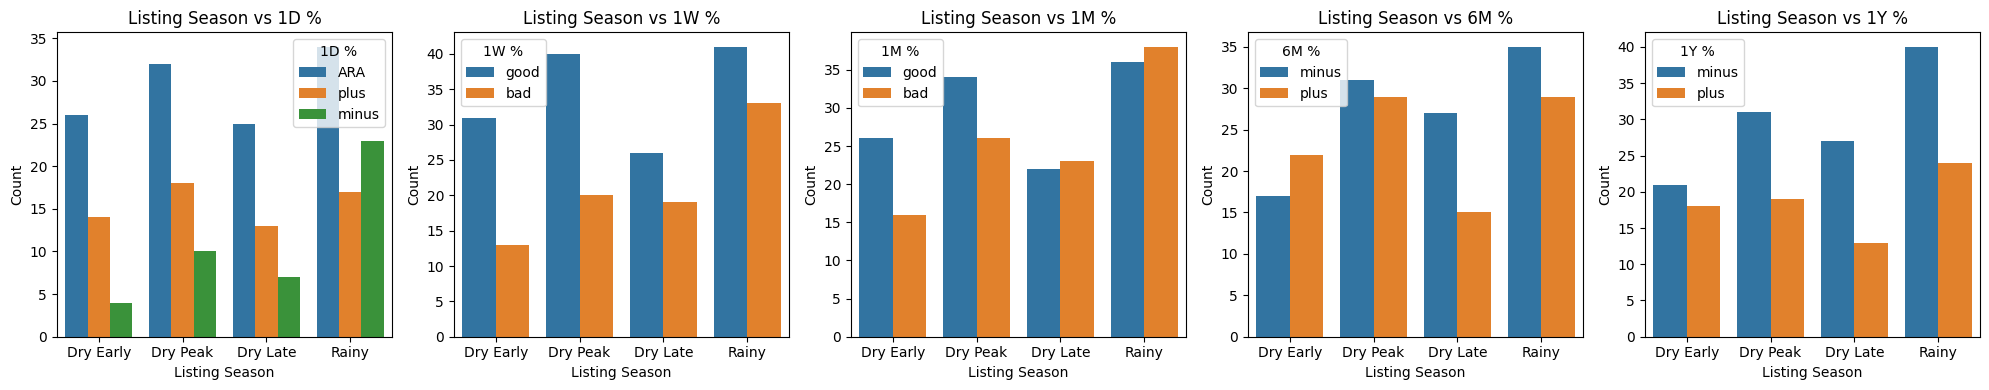

In [32]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, col in enumerate(['1D %', '1W %', '1M %', '6M %', '1Y %']):
    sns.countplot(x=df['Listing Season'], hue=df[col], ax=axes[i])
    axes[i].set_title(f'Listing Season vs {col}')
    axes[i].set_xlabel('Listing Season')
    axes[i].set_ylabel('Count')
    axes[i].legend(title=col, loc='best')
plt.tight_layout()
plt.show()

#### Financials

##### Part 1

In [33]:
df['ipo_raised_fund'] = df['Listed Share'] * df['Harga Final'] * df['Persen Saham Ditawarkan']

df['equity'] = df['Total Aset'] - df['Total Liabilitas']
df['leverage'] = df['Total Liabilitas'] / df['equity']
df['turnover'] = df['Pendapatan'] / df['Total Aset']


df['PER'] = df['Harga Final'] / (df['Laba Berjalan (Bukan Komperhensif)'] / df['Listed Share'])
df['PBV'] = df['Harga Final'] / (df['equity'] / df['Listed Share'])
df['PER'] = df['PER'].clip(upper=100)
df['PBV'] = df['PBV'].clip(upper=10)

df['ROA'] = df['Laba Berjalan (Bukan Komperhensif)'] / df['Total Aset']
df['ROE'] = df['Laba Berjalan (Bukan Komperhensif)'] / df['equity']
df['NPM'] = df['Laba Berjalan (Bukan Komperhensif)'] / df['Pendapatan']

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 38 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Ticker                              223 non-null    object 
 1   Nama Perusahaan                     223 non-null    object 
 2   lead_underwriter                    223 non-null    object 
 3   underwriter_freq_category           223 non-null    object 
 4   underwriter_avg_aset_category       223 non-null    object 
 5   Sektor                              223 non-null    object 
 6   Papan Pencatatan                    223 non-null    object 
 7   Ownership                           223 non-null    object 
 8   Listed Share                        223 non-null    float64
 9   Persen Saham Ditawarkan             223 non-null    float64
 10  Rencana Penggunaan Dana IPO         223 non-null    object 
 11  Valuation Currency                  223 non-n

In [34]:
df = df.drop(['Listed Share', 'Rencana Penggunaan Dana IPO', 'Valuation Currency', 'Total Liabilitas', 'Laba Kotor', 'Laba Berjalan (Bukan Komperhensif)'], axis=1)

In [35]:
cols = list(df.columns)
cols_to_move = cols[11:17]
cols_new = [col for col in cols if col not in cols_to_move] + cols_to_move
df = df[cols_new]

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Ticker                         223 non-null    object 
 1   Nama Perusahaan                223 non-null    object 
 2   lead_underwriter               223 non-null    object 
 3   underwriter_freq_category      223 non-null    object 
 4   underwriter_avg_aset_category  223 non-null    object 
 5   Sektor                         223 non-null    object 
 6   Papan Pencatatan               223 non-null    object 
 7   Ownership                      223 non-null    object 
 8   Persen Saham Ditawarkan        223 non-null    float64
 9   Total Aset                     223 non-null    float64
 10  Pendapatan                     223 non-null    float64
 11  avg_last3_weighted_1dpct       204 non-null    float64
 12  avg_last3_weighted_1wpct       204 non-null    flo

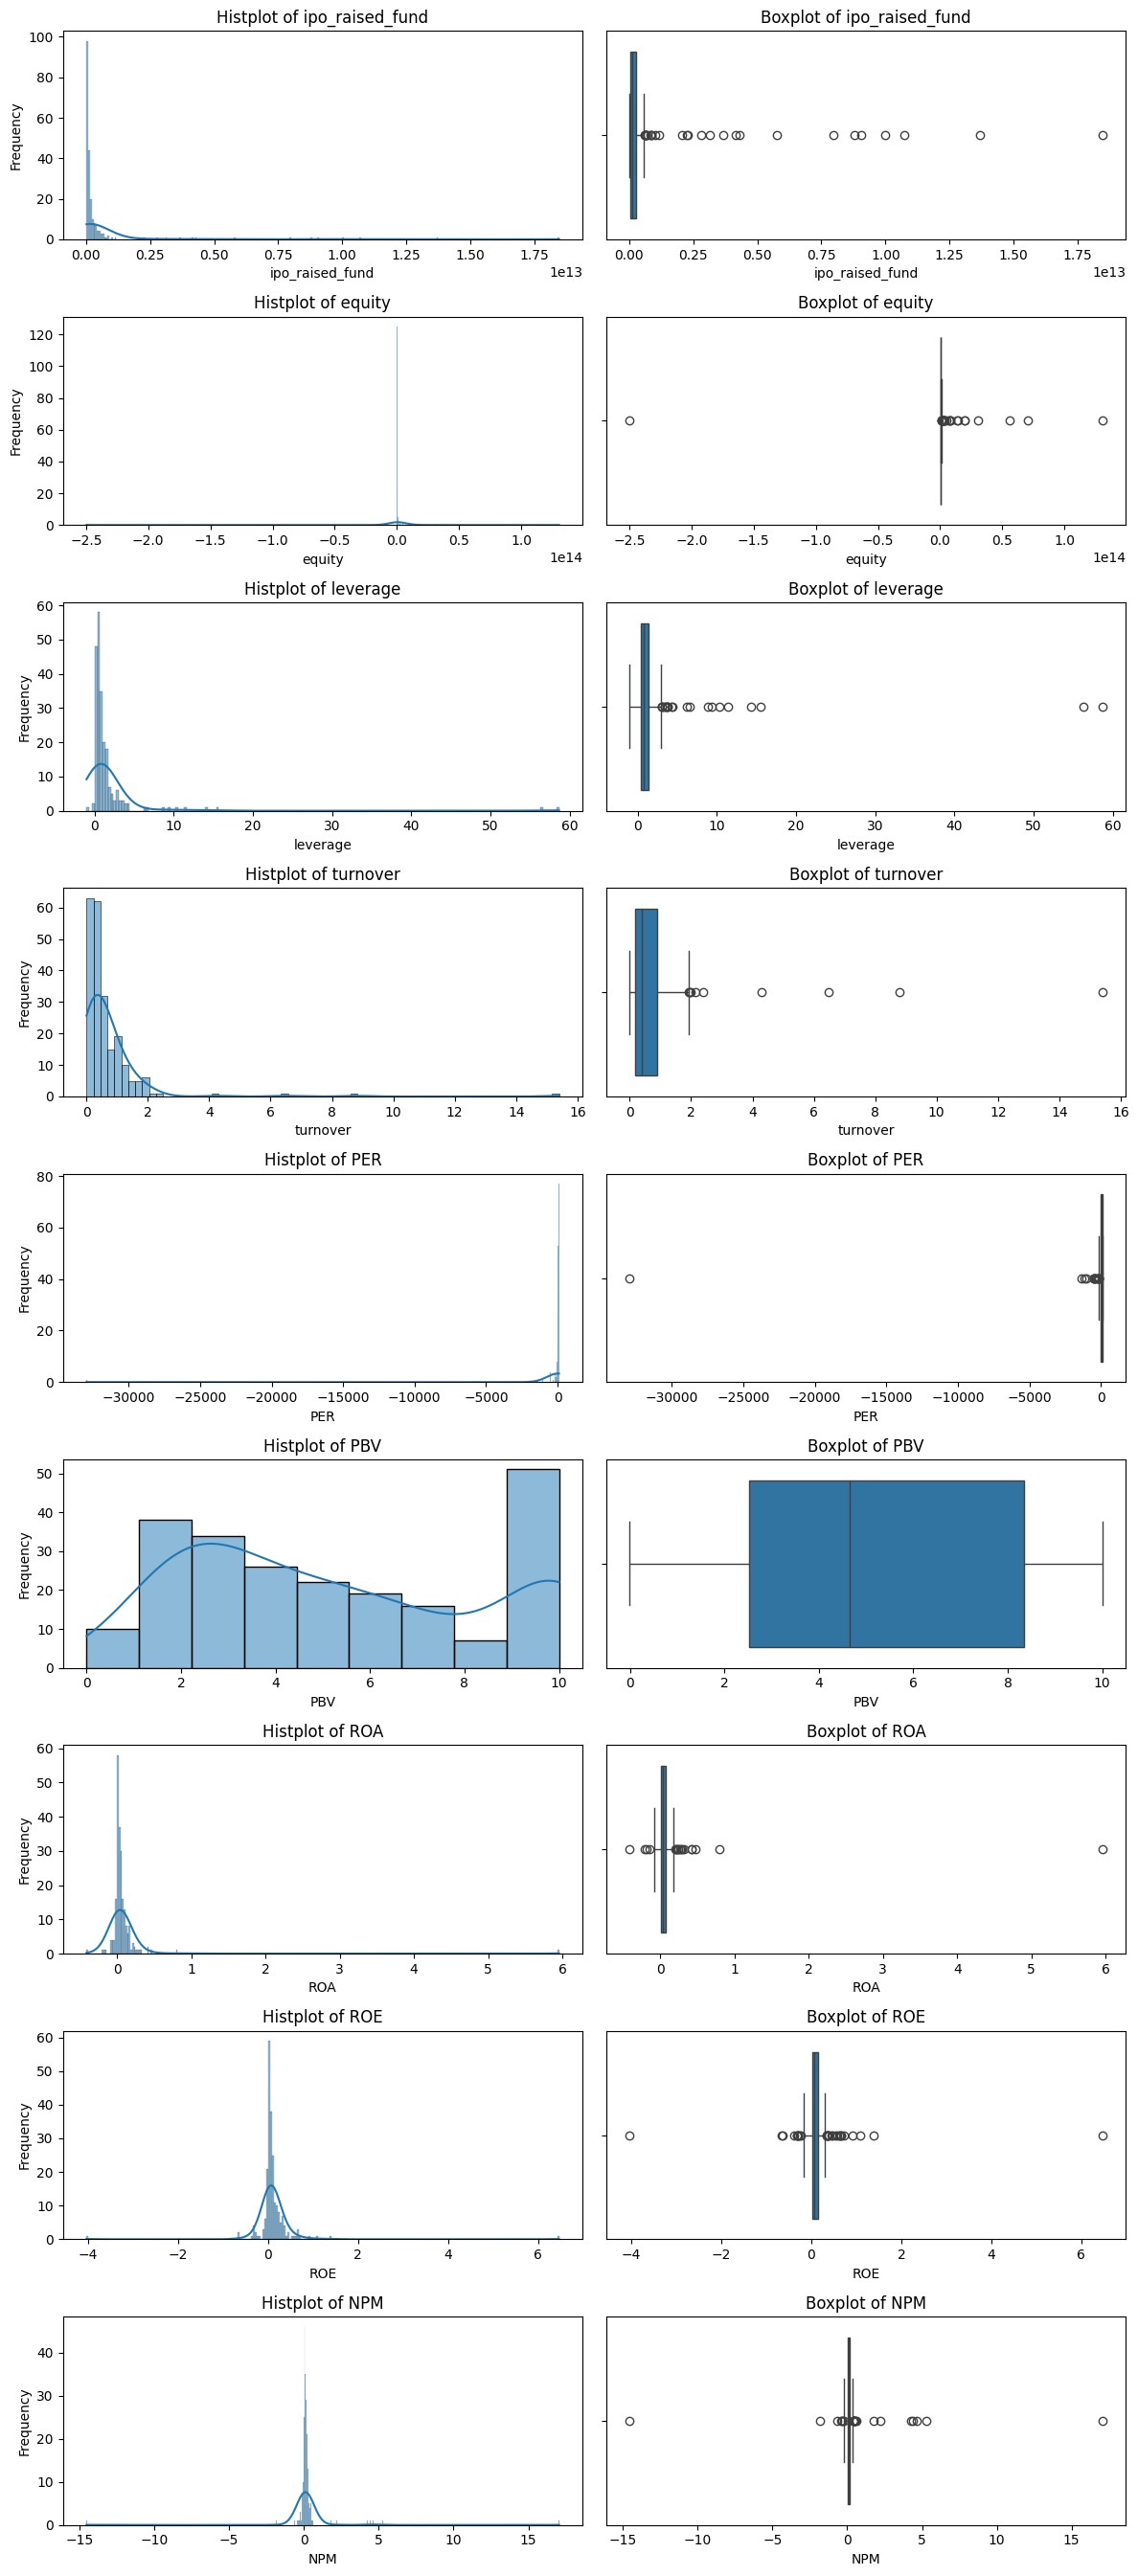

In [37]:
cols_to_plot = df.columns[17:26]
fig, axes = plt.subplots(len(cols_to_plot), 2, figsize=(12, 3 * len(cols_to_plot)))

for idx, col in enumerate(cols_to_plot):
    sns.histplot(df[col].dropna(), ax=axes[idx, 0], kde=True)
    axes[idx, 0].set_title(f'Histplot of {col}')
    axes[idx, 0].set_xlabel(col)
    axes[idx, 0].set_ylabel('Frequency')
    
    sns.boxplot(x=df[col].dropna(), ax=axes[idx, 1], orient='h')
    axes[idx, 1].set_title(f'Boxplot of {col}')
    axes[idx, 1].set_xlabel(col)

plt.tight_layout()
plt.show()

In [38]:
cols_to_log = [col for col in df.columns[17:26] if col != 'PBV']

for col in cols_to_log:
    df[col] = np.log1p(df[col].clip(lower=1e-9))

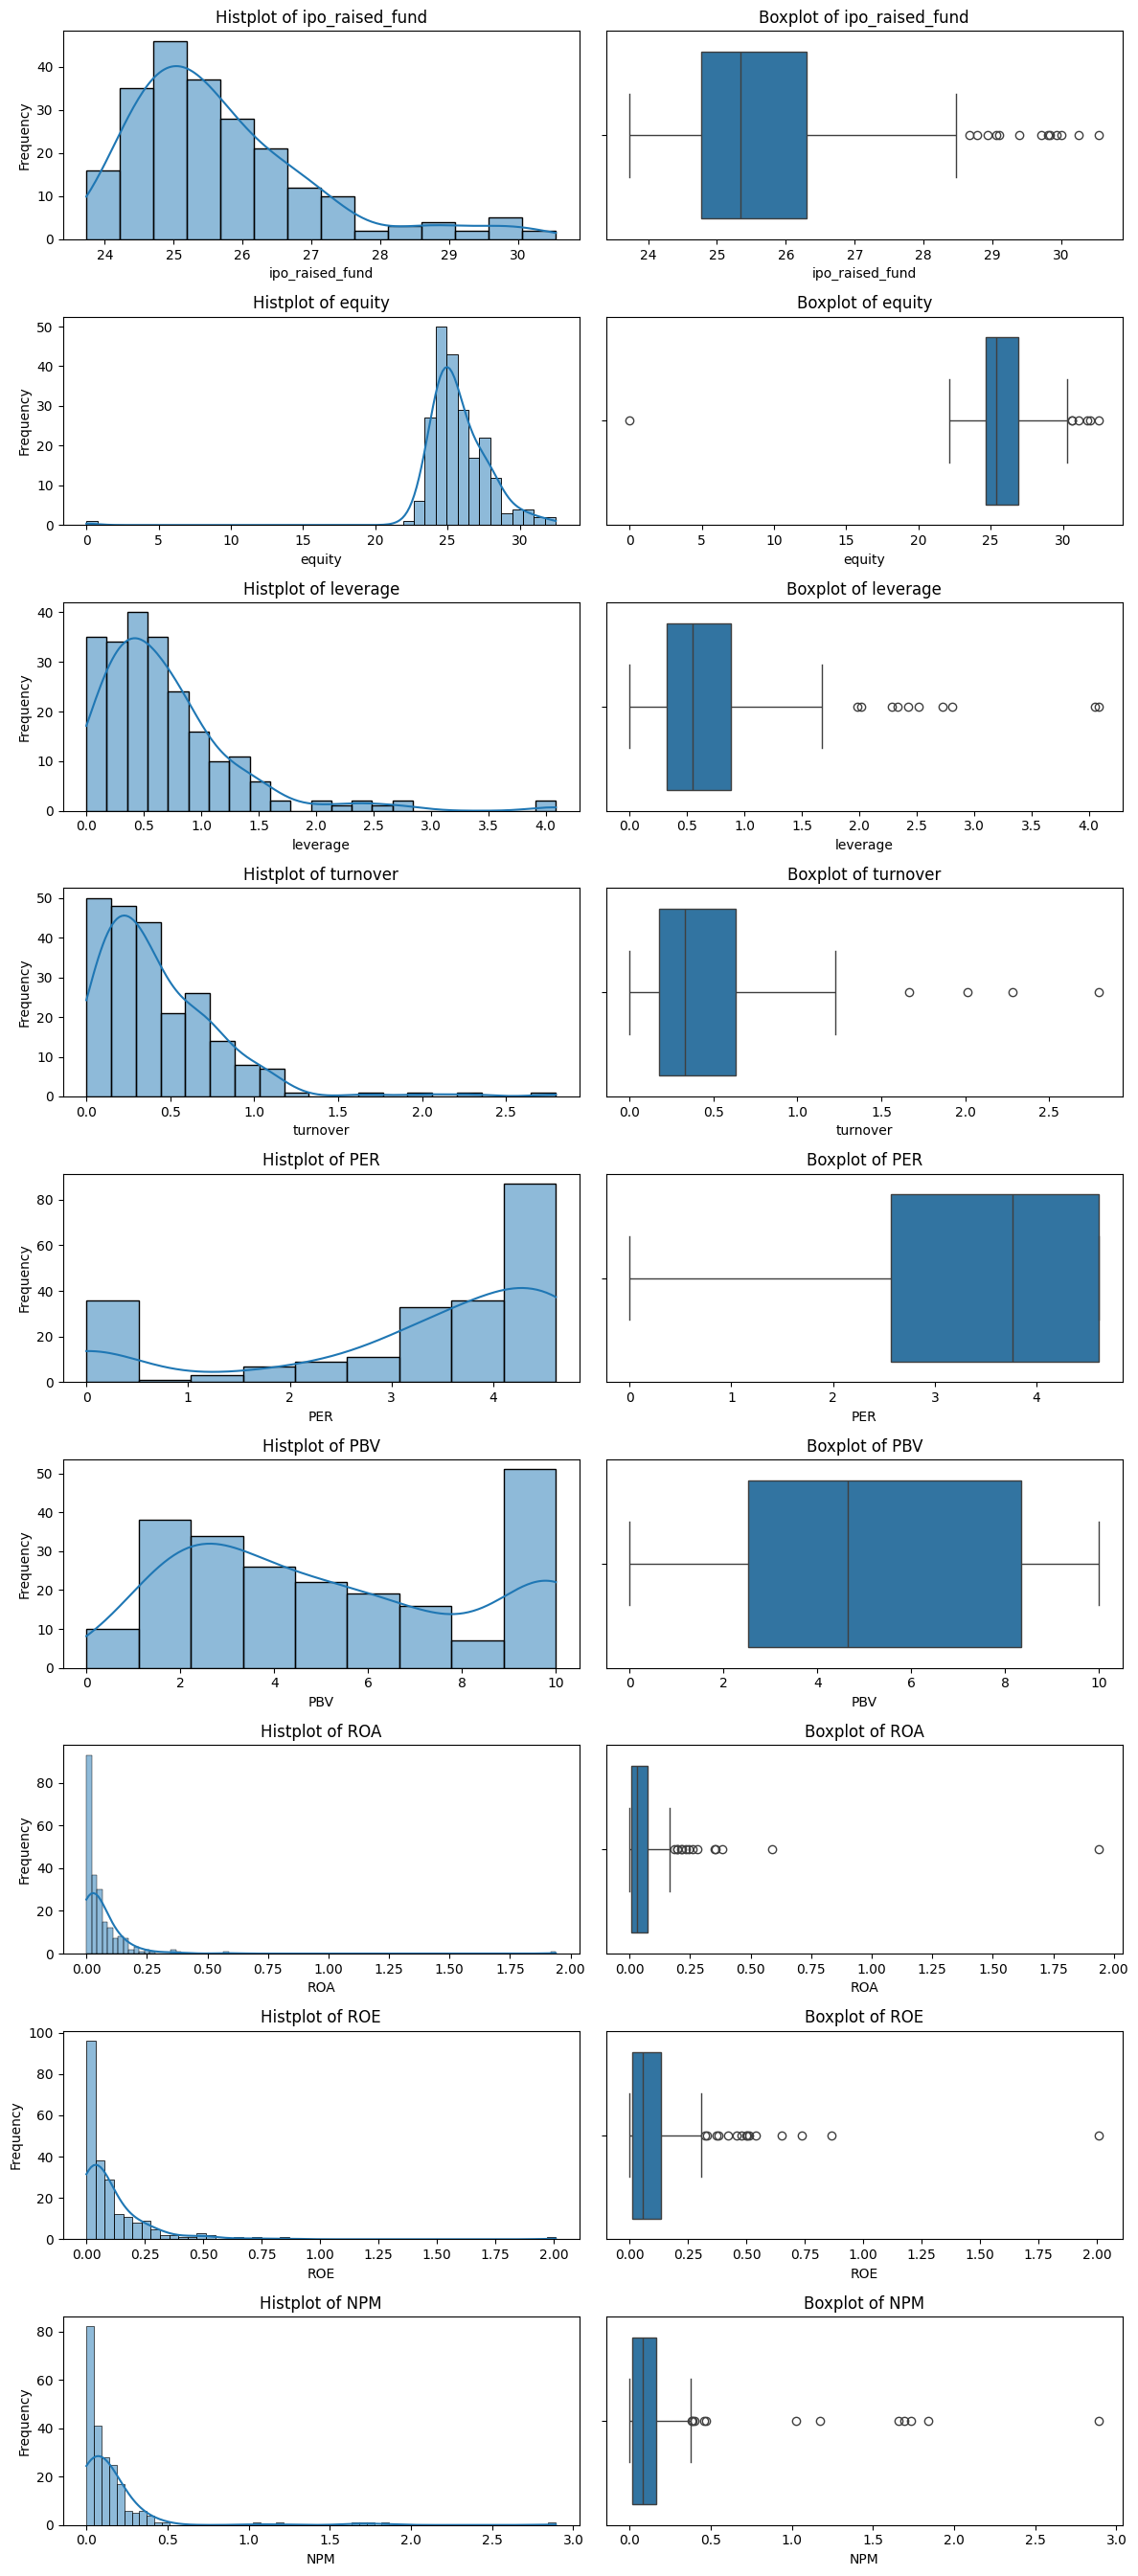

In [39]:
cols_to_plot = df.columns[17:26]
fig, axes = plt.subplots(len(cols_to_plot), 2, figsize=(12, 3 * len(cols_to_plot)))

for idx, col in enumerate(cols_to_plot):
    sns.histplot(df[col].dropna(), ax=axes[idx, 0], kde=True)
    axes[idx, 0].set_title(f'Histplot of {col}')
    axes[idx, 0].set_xlabel(col)
    axes[idx, 0].set_ylabel('Frequency')
    
    sns.boxplot(x=df[col].dropna(), ax=axes[idx, 1], orient='h')
    axes[idx, 1].set_title(f'Boxplot of {col}')
    axes[idx, 1].set_xlabel(col)

plt.tight_layout()
plt.show()

##### Total aset

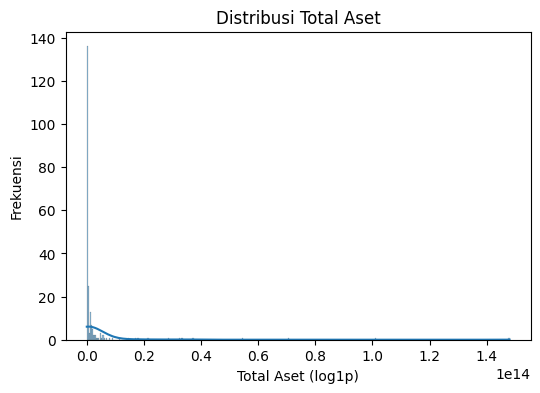

In [40]:
plt.figure(figsize=(6, 4))
sns.histplot(df['Total Aset'].dropna(), kde=True)
plt.title('Distribusi Total Aset')
plt.xlabel('Total Aset (log1p)')
plt.ylabel('Frekuensi')
plt.show()

In [41]:
df['Total Aset'] = np.log1p(df['Total Aset'].clip(lower=1e-9))

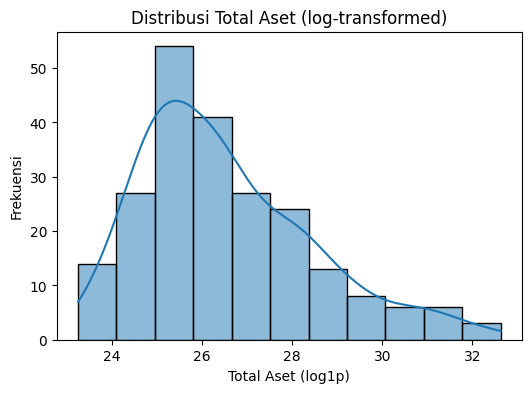

In [42]:
plt.figure(figsize=(6, 4))
sns.histplot(df['Total Aset'].dropna(), kde=True)
plt.title('Distribusi Total Aset (log-transformed)')
plt.xlabel('Total Aset (log1p)')
plt.ylabel('Frekuensi')
plt.show()

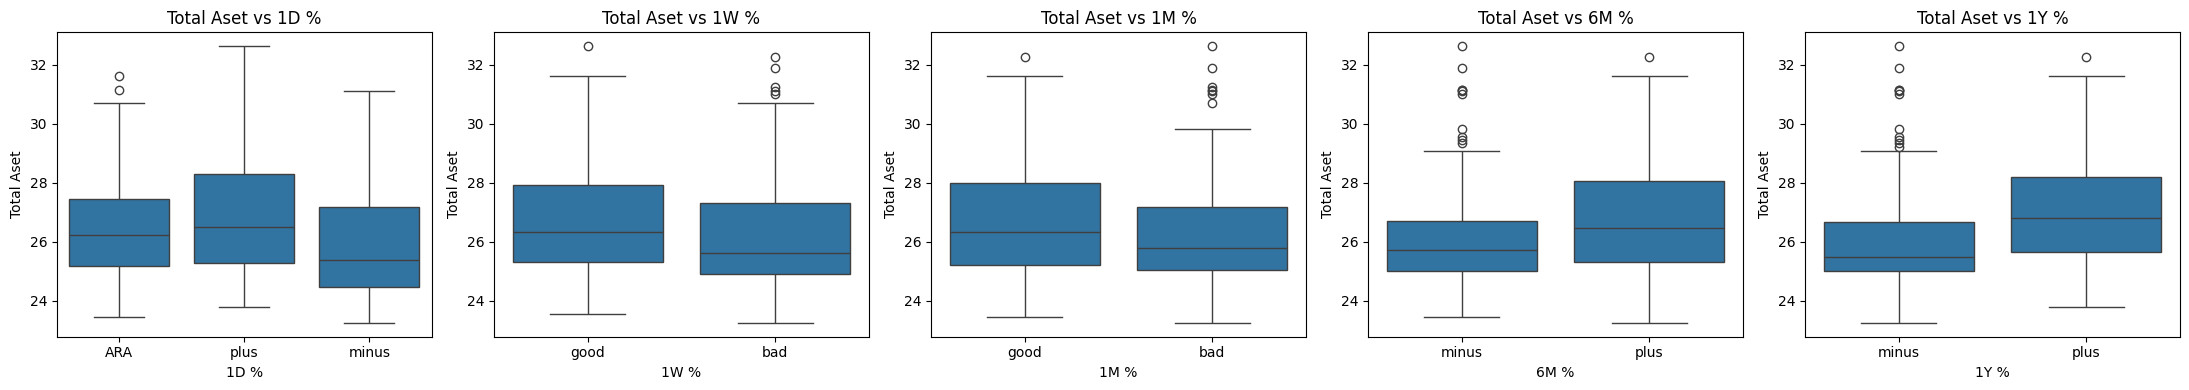

In [44]:
fig, axes = plt.subplots(1, len(target_cols), figsize=(22, 4))
for i, col in enumerate(target_cols):
    sns.boxplot(x=df[col], y=df['Total Aset'], ax=axes[i])
    axes[i].set_title(f'Total Aset vs {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Total Aset')
plt.tight_layout()
plt.show()

In [49]:
df['Total Aset'].describe()

count    223.000000
mean      26.534523
std        1.915678
min       23.248366
25%       25.088343
50%       26.191326
75%       27.804833
max       32.628233
Name: Total Aset, dtype: float64

In [50]:
df['total_aset_category'] = pd.cut(
    df['Total Aset'],
    bins=[-float('inf'), df['Total Aset'].quantile(0.25), df['Total Aset'].quantile(0.75), float('inf')],
    labels=['low', 'mid', 'high']
)

In [51]:
df['total_aset_category'] = df['total_aset_category'].astype('object')

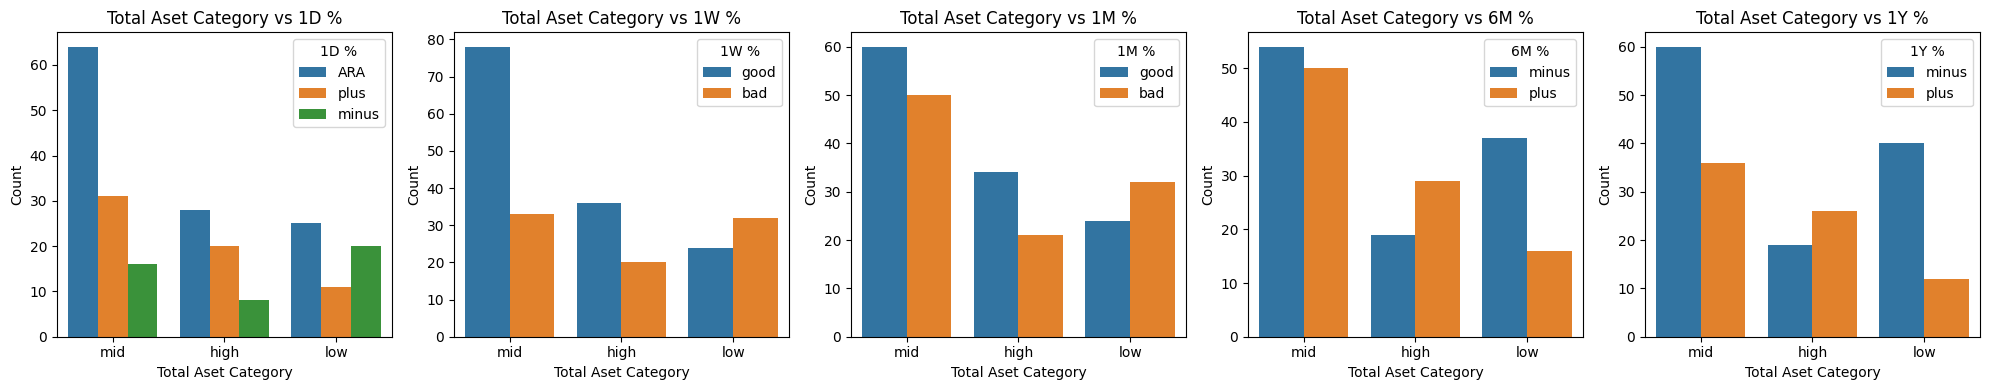

In [52]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
target_cols = ['1D %', '1W %', '1M %', '6M %', '1Y %']

for i, col in enumerate(target_cols):
    sns.countplot(x=df['total_aset_category'], hue=df[col], ax=axes[i])
    axes[i].set_title(f'Total Aset Category vs {col}')
    axes[i].set_xlabel('Total Aset Category')
    axes[i].set_ylabel('Count')
    axes[i].legend(title=col, loc='best')

plt.tight_layout()
plt.show()

#### Price Category

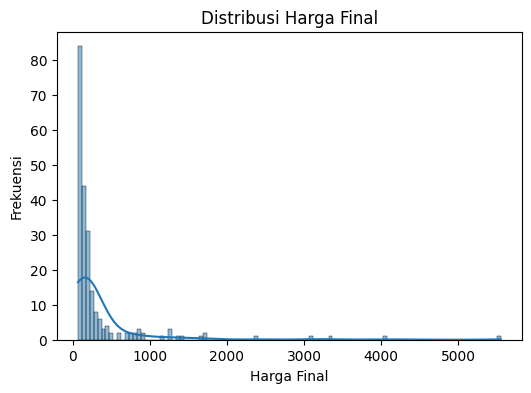

In [54]:
plt.figure(figsize=(6, 4))
sns.histplot(df['Harga Final'].dropna(), kde=True)
plt.title('Distribusi Harga Final')
plt.xlabel('Harga Final')
plt.ylabel('Frekuensi')
plt.show()

In [ ]:
# < 200
# 200 -500
# 500 - 2000
# 2000 - 5000
# > 5000

In [55]:
df['Harga Final'] = np.log1p(df['Harga Final'])

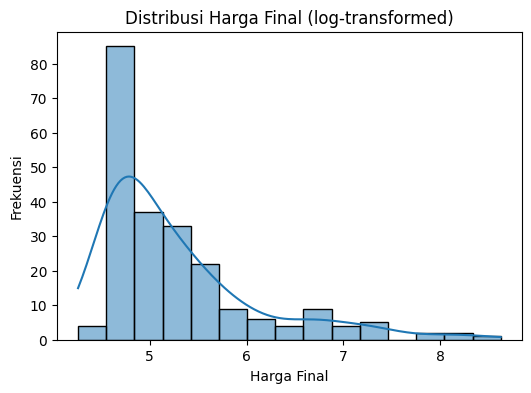

In [56]:
plt.figure(figsize=(6, 4))
sns.histplot(df['Harga Final'].dropna(), kde=True)
plt.title('Distribusi Harga Final (log-transformed)')
plt.xlabel('Harga Final')
plt.ylabel('Frekuensi')
plt.show()

In [58]:
df['price_category'] = pd.qcut(
    df['Harga Final'], 
    q=4, 
    labels=['very low', 'low', 'mid', 'high']
)

print(df['price_category'].unique())
print(df['price_category'].value_counts())


['low', 'high', 'very low', 'mid']
Categories (4, object): ['very low' < 'low' < 'mid' < 'high']
price_category
very low    58
high        56
mid         55
low         54
Name: count, dtype: int64


In [61]:
_, bin_edges = pd.qcut(df['Harga Final'], q=4, retbins=True, duplicates='drop')
for i in range(len(bin_edges) - 1):
    print(f"Bin {i+1}: {np.expm1(bin_edges[i]):.2f} – {np.expm1(bin_edges[i+1]):.2f}")

Bin 1: 70.00 – 105.00
Bin 2: 105.00 – 149.00
Bin 3: 149.00 – 259.97
Bin 4: 259.97 – 5550.00


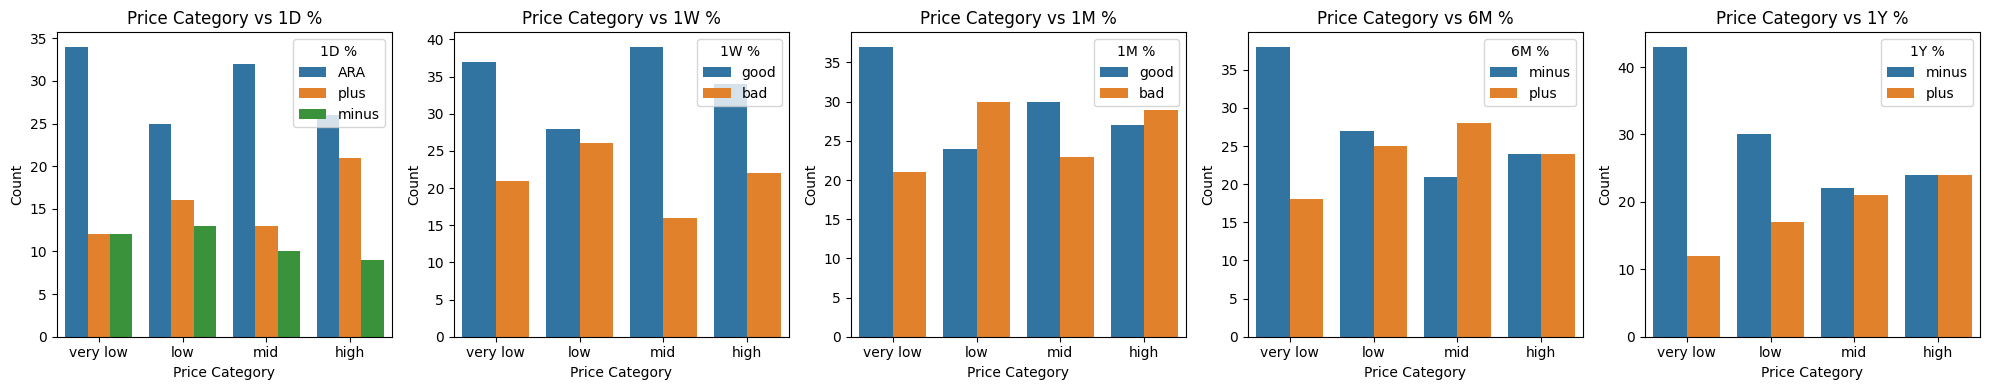

In [62]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, col in enumerate(['1D %', '1W %', '1M %', '6M %', '1Y %']):
    sns.countplot(x=df['price_category'], hue=df[col], ax=axes[i])
    axes[i].set_title(f'Price Category vs {col}')
    axes[i].set_xlabel('Price Category')
    axes[i].set_ylabel('Count')
    axes[i].legend(title=col, loc='best')
plt.tight_layout()
plt.show()


In [71]:
df['price_category'] = df['price_category'].astype('object')

#### Ownership

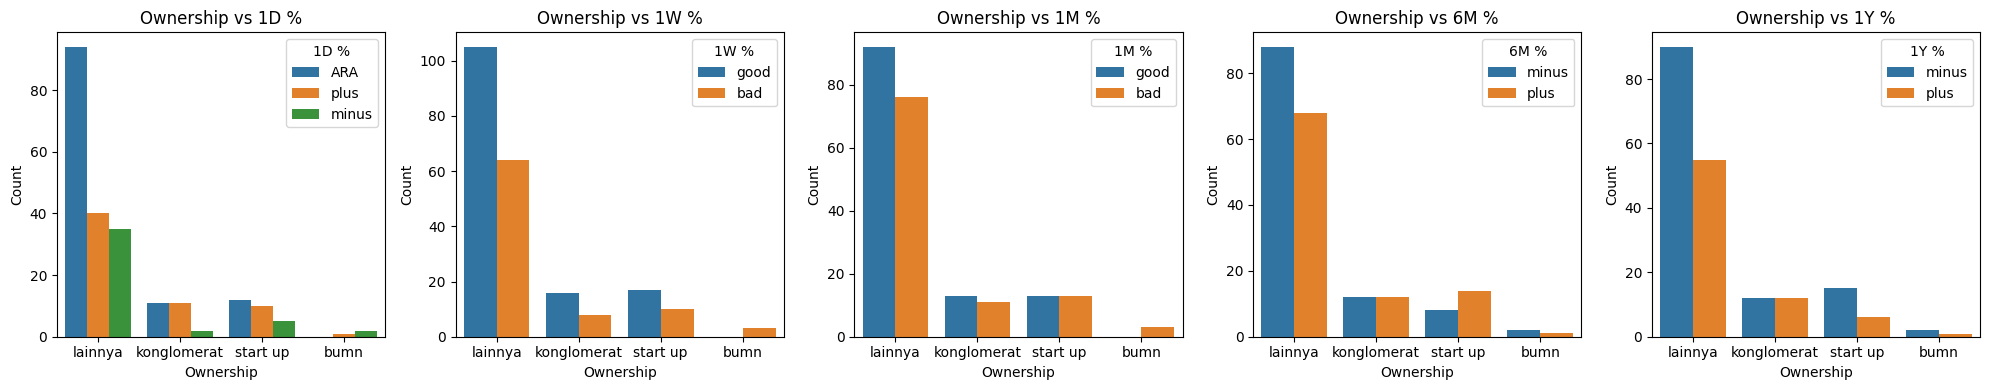

In [68]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, col in enumerate(['1D %', '1W %', '1M %', '6M %', '1Y %']):
    sns.countplot(x=df['Ownership'], hue=df[col], ax=axes[i])
    axes[i].set_title(f'Ownership vs {col}')
    axes[i].set_xlabel('Ownership')
    axes[i].set_ylabel('Count')
    axes[i].legend(title=col, loc='best')
plt.tight_layout()
plt.show()

### Encoding

In [ ]:
df = df.drop('Ticker', axis = 1)
df = df.drop('Nama Perusahaan', axis = 1)

In [74]:
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    if col != 'Underwriter' and col != 'lead_underwriter':
        print(f"{col}:")
        print(df[col].unique())
        print('-' * 40)

underwriter_freq_category:
['high' 'mid' 'low']
----------------------------------------
underwriter_avg_aset_category:
['low' 'high' 'mid']
----------------------------------------
Sektor:
['Energy' 'Basic Materials' 'Financials' 'Healthcare' 'Technology'
 'Transportation & Logistic' 'Consumer Non-Cyclicals' 'Industrials'
 'Consumer Cyclicals' 'Infrastructures' 'Properties & Real Estate']
----------------------------------------
Papan Pencatatan:
['utama' 'pengembangan' 'pemantauan khusus' 'akselerasi' 'ekonomi baru']
----------------------------------------
Ownership:
['lainnya' 'konglomerat' 'start up' 'bumn']
----------------------------------------
Listing Season:
['Dry Early' 'Dry Peak' 'Dry Late' 'Rainy']
----------------------------------------
1D %:
['ARA' 'plus' 'minus']
----------------------------------------
1W %:
['good' 'bad']
----------------------------------------
1M %:
['good' 'bad' nan]
----------------------------------------
6M %:
['minus' 'plus' nan]
------------

In [77]:
orders = {
    'underwriter_freq_category': ['low', 'mid', 'high'],
    'underwriter_avg_aset_category': ['low', 'mid', 'high'],
    'total_aset_category': ['low', 'mid', 'high'],
    'price_category': ['very low', 'low', 'mid', 'high'],
}

manual_orders = orders  # alias for clarity

label_encoders = {}
encoded_mappings = {}

for col in categorical_cols:
    le = LabelEncoder()
    if col in manual_orders:
        df[col] = pd.Categorical(df[col], categories=manual_orders[col], ordered=True)
        le.classes_ = np.array(manual_orders[col])
        df[col] = le.transform(df[col])
    else:
        df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    encoded_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))

for col, mapping in encoded_mappings.items():
    print(f"{col}: {mapping}")



lead_underwriter: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38: 38, 39: 39, 40: 40, 41: 41, 42: 42}
underwriter_freq_category: {'low': 0, 'mid': 1, 'high': 2}
underwriter_avg_aset_category: {'low': 0, 'mid': 1, 'high': 2}
Sektor: {'Basic Materials': 0, 'Consumer Cyclicals': 1, 'Consumer Non-Cyclicals': 2, 'Energy': 3, 'Financials': 4, 'Healthcare': 5, 'Industrials': 6, 'Infrastructures': 7, 'Properties & Real Estate': 8, 'Technology': 9, 'Transportation & Logistic': 10}
Papan Pencatatan: {'akselerasi': 0, 'ekonomi baru': 1, 'pemantauan khusus': 2, 'pengembangan': 3, 'utama': 4}
Ownership: {'bumn': 0, 'konglomerat': 1, 'lainnya': 2, 'start up': 3}
Listing Season: {'Dry Early': 0, 'Dry Late': 1, 'Dry Peak': 2, 'Rainy': 3}
1D %: {'ARA': 0, 'minus': 1

### Organizing and Saving Data

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   lead_underwriter               223 non-null    int64  
 1   underwriter_freq_category      223 non-null    int32  
 2   underwriter_avg_aset_category  223 non-null    int32  
 3   Sektor                         223 non-null    int32  
 4   total_aset_category            223 non-null    int32  
 5   price_category                 223 non-null    int32  
 6   Papan Pencatatan               223 non-null    int32  
 7   Ownership                      223 non-null    int32  
 8   Persen Saham Ditawarkan        223 non-null    float64
 9   Total Aset                     223 non-null    float64
 10  Pendapatan                     223 non-null    float64
 11  avg_last3_weighted_1dpct       204 non-null    float64
 12  avg_last3_weighted_1wpct       204 non-null    flo

In [81]:
cols = list(df.columns)
cols_to_move = ['total_aset_category', 'price_category']
sektor_idx = cols.index('Sektor')
for col in cols_to_move:
    cols.remove(col)
for i, col in enumerate(cols_to_move):
    cols.insert(sektor_idx + 1 + i, col)
df = df[cols]

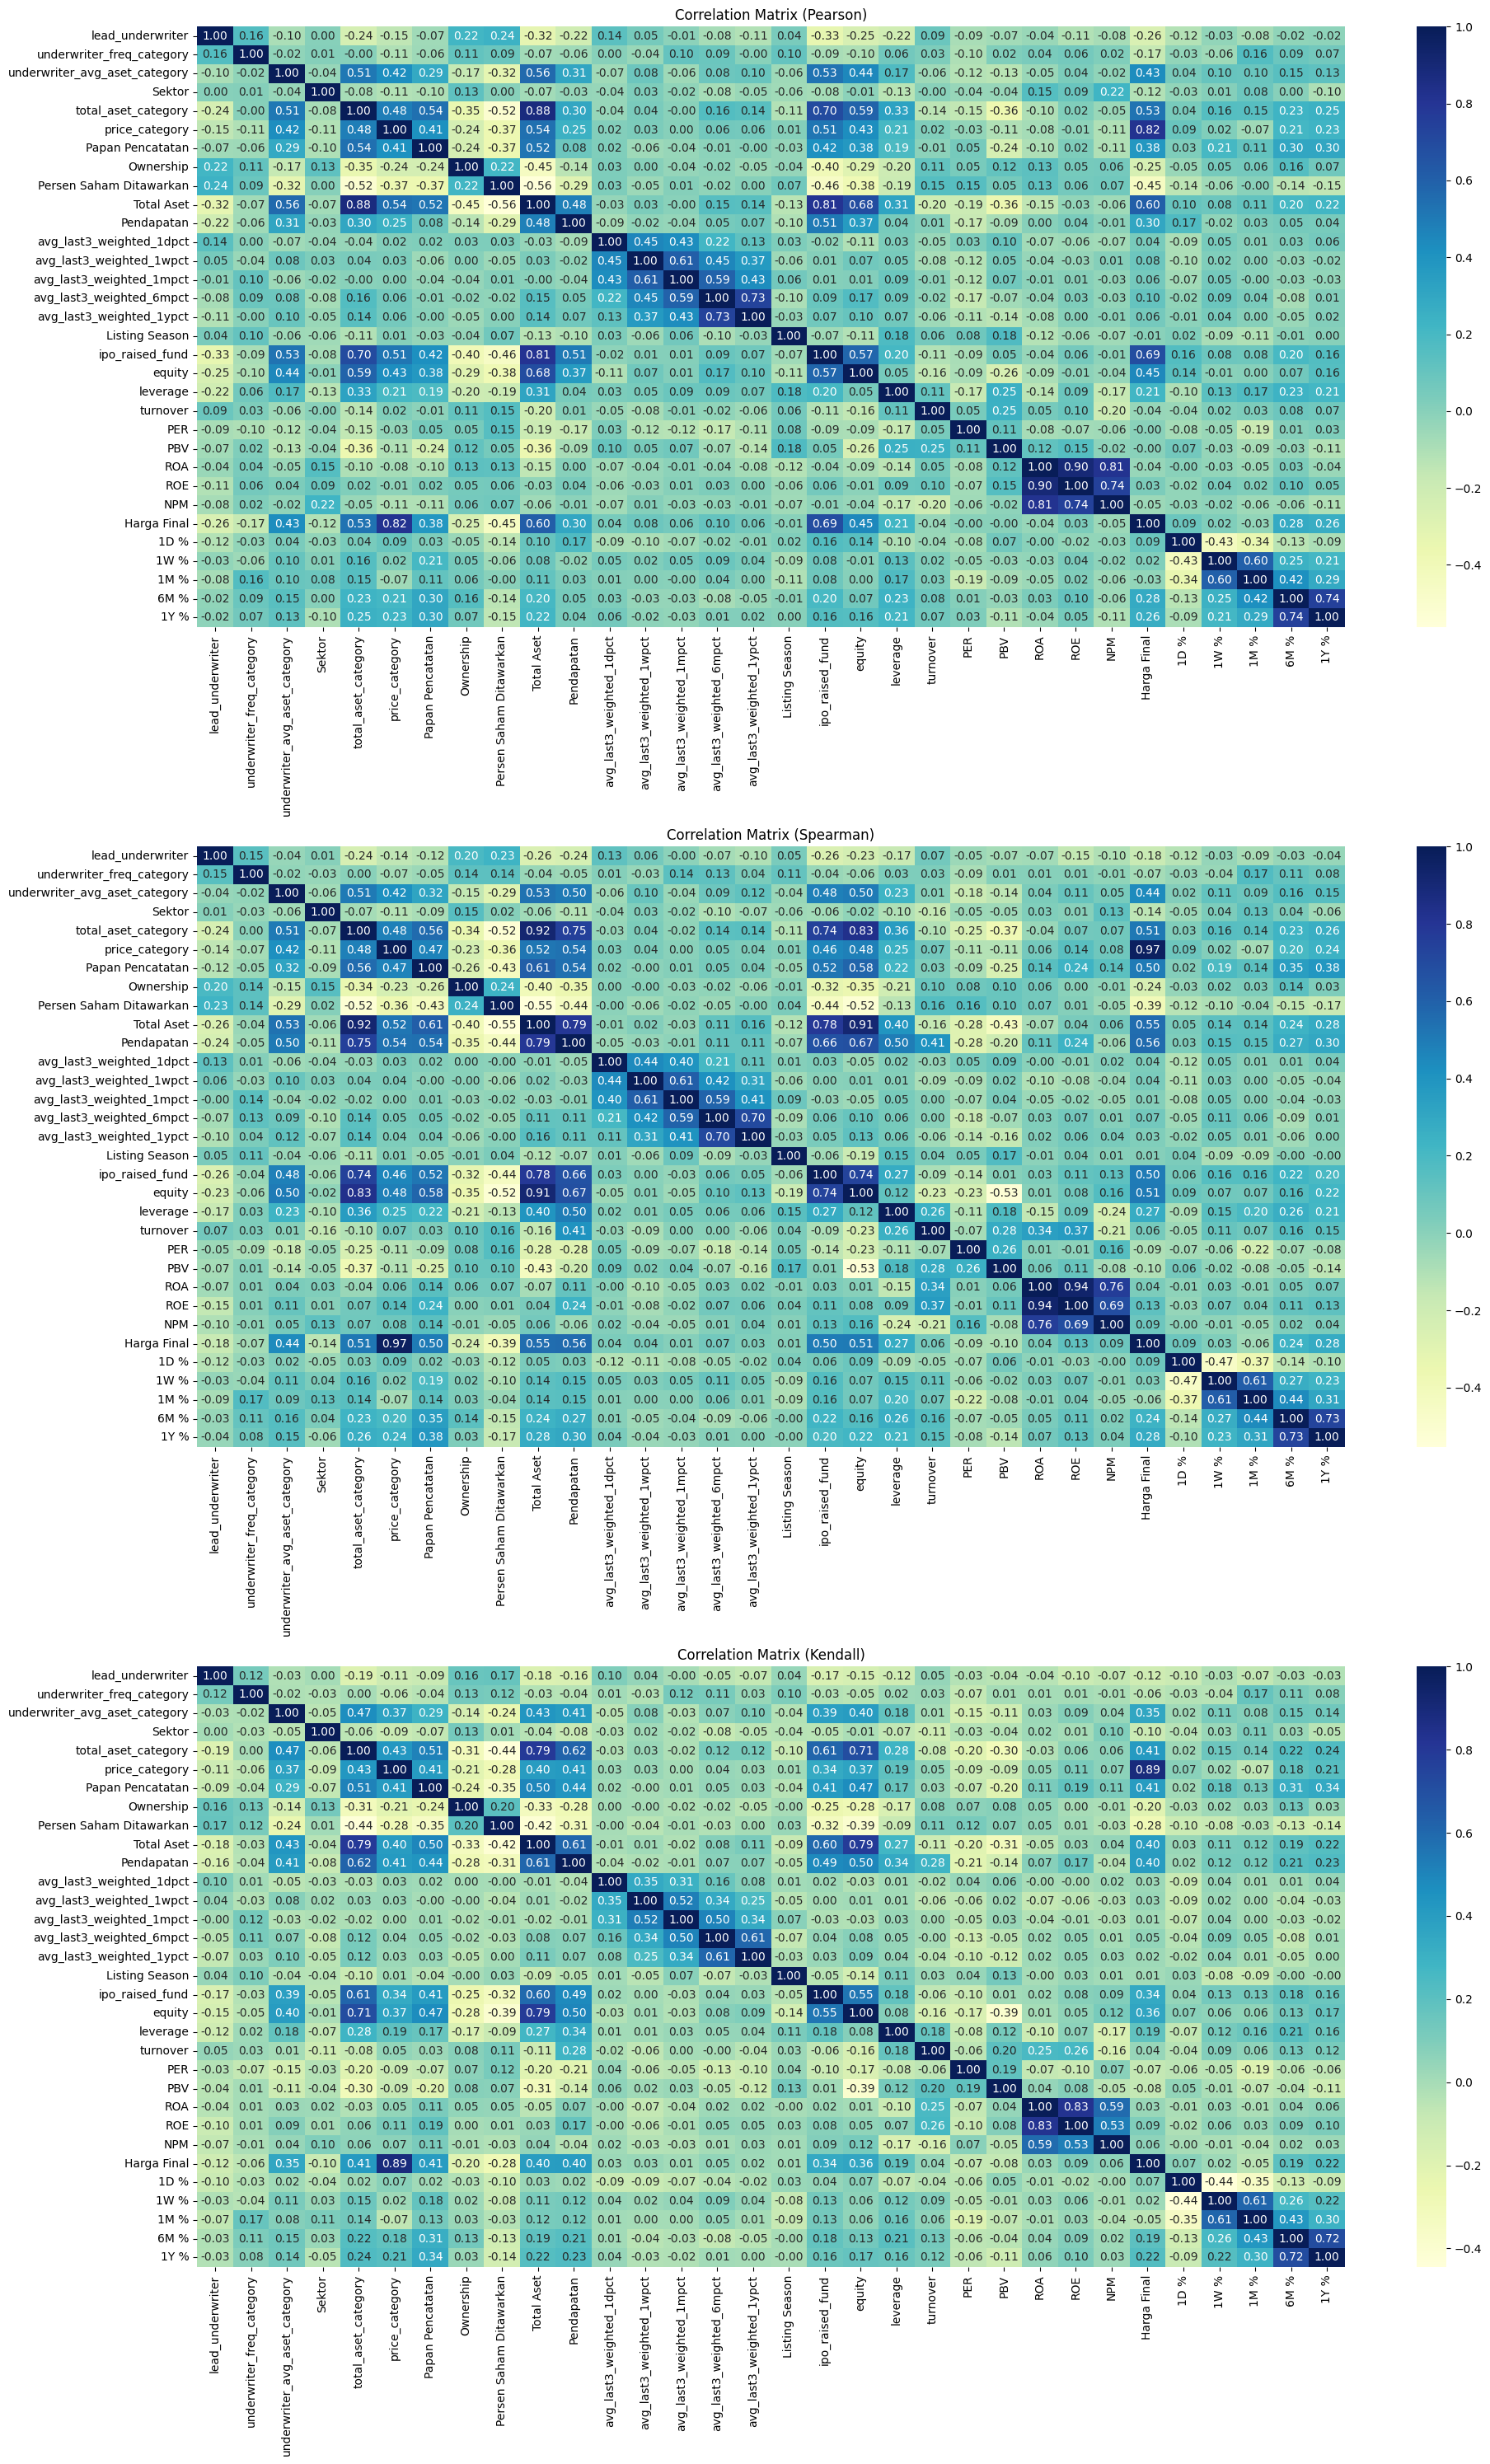

In [86]:
plt.figure(figsize=(20, 10 * len(corr_methods)))

for i, method in enumerate(corr_methods, 1):
    plt.subplot(len(corr_methods), 1, i)
    corr = df.iloc[:].corr(method=method)
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='YlGnBu', cbar=True)
    plt.title(f'Correlation Matrix ({method.title()})')

plt.tight_layout()
plt.show()

In [89]:
# buat save dataset terpisah yang udah diolah

custom_columns = [
    ('Ownership', 'ownership'),    
    ('Papan Pencatatan', 'papan_pencatatan'),
    ('ipo_raised_fund', 'IPO Raised Fund'),    
    ('Persen Saham Ditawarkan', 'float'),    
    ('price_category', 'price_cat'),

    ('lead_underwriter', 'lead_underwriter'),
    ('underwriter_freq_category', 'underwriter_freq_cat'),
    ('underwriter_avg_aset_category', 'underwriter_avg_aset_cat'),
    ('avg_last3_weighted_1dpct', 'avg_last3_weighted_1dpct'),
    ('avg_last3_weighted_1wpct', 'avg_last3_weighted_1wpct'),    
    ('avg_last3_weighted_1mpct', 'avg_last3_weighted_1mpct'),
    ('avg_last3_weighted_6mpct', 'avg_last3_weighted_6mpct'),
    ('avg_last3_weighted_1ypct', 'avg_last3_weighted_1ypct'),

    ('Total Aset', 'total_aset'),
    ('total_aset_category', 'total_aset_cat'),
    ('equity', 'equity'),
    ('leverage', 'leverage_ratio'),
    ('Pendapatan', 'revenue'),    
    ('turnover', 'turnover_ratio'),
    ('ROE', 'return_on_equity'),

    ('1D %', '1d_pct'),
    ('1W %', '1w_pct'),
    ('1M %', '1m_pct'),
    ('6M %', '6m_pct'),
    ('1Y %', '1y_pct'),

    ('1D %', '1d'),
    ('1W %', '1w'),
    ('1M %', '1m'),
    ('6M %', '6m'),
    ('1Y %', '1y'),
]

orig_cols, new_names = zip(*custom_columns)

df_custom = df[list(orig_cols)].copy()
df_custom.columns = new_names

df_custom.head()

ownership  papan_pencatatan  IPO Raised Fund   float  price_cat  \
0          2                 4        24.290267  0.0956          1   
1          1                 3        28.658473  0.1500          3   
2          2                 2        27.150335  0.1500          3   
3          1                 4        26.081580  0.0726          3   
4          2                 3        24.635289  0.2500          0   

   lead_underwriter  underwriter_freq_cat  underwriter_avg_aset_cat  \
0                38                     2                         0   
1                 3                     2                         2   
2                 2                     1                         1   
3                10                     2                         1   
4                38                     2                         0   

   avg_last3_weighted_1dpct  avg_last3_weighted_1wpct  ...  1d_pct  1w_pct  \
0                       NaN                       NaN  ...       0       1   
1                       NaN                       NaN  ...       2       0   
2                       NaN                       NaN  ...       0       0   
3                       NaN                       NaN  ...       0       1   
4                       1.0                       1.0  ...       0       1   

   1m_pct  6m_pct  1y_pct  1d  1w  1m  6m  1y  
0       1       0       0   0   1   1   0   0  
1       0       0       0   2   0   0   0   0  
2       0       1       1   0   0   0   1   1  
3       1       1       1   0   1   1   1   1  
4       1       1       1   0   1   1   1   1  

[5 rows x 30 columns]

In [90]:
df_custom.to_csv('processed-data.csv', index=False)

### Training

In [ ]:
onehot_cols = ['lead_underwriter']
onehot_expanded = []

for col in onehot_cols:
    onehot_expanded += [c for c in df.columns if c.startswith(col + '_')]

feature_columns = [
    'underwriter_freq_category', 'underwriter_avg_aset_category', 
    'Total Aset', 'Pendapatan', 'ipo_raised_fund', 'leverage', 'turnover', 
] + onehot_expanded

target_columns = ['1D %', '1W %', '1M %', '6M %', '1Y %']

X = df[feature_columns]
y = df[target_columns]

In [ ]:
X_1d, X_1w, X_1m, X_6m, X_1y = [X.copy() for _ in range(5)]
y_1d = y['1D %'].copy()
y_1w = y['1W %'].copy()
y_1m = y['1M %'].copy()
y_6m = y['6M %'].copy()
y_1y = y['1Y %'].copy()

In [ ]:
mask_1m = y_1m != 2
mask_6m = y_6m != 2
mask_1y = y_1y != 2

X_1m_clean = X_1m[mask_1m]
y_1m_clean = y_1m[mask_1m]
X_6m_clean = X_6m[mask_6m]
y_6m_clean = y_6m[mask_6m]
X_1y_clean = X_1y[mask_1y]
y_1y_clean = y_1y[mask_1y]

In [ ]:
X_1d_train, X_1d_test, y_1d_train, y_1d_test = train_test_split(X_1d, y_1d, test_size=0.2, random_state=42)
X_1w_train, X_1w_test, y_1w_train, y_1w_test = train_test_split(X_1w, y_1w, test_size=0.2, random_state=42)
X_1m_train, X_1m_test, y_1m_train, y_1m_test = train_test_split(X_1m_clean, y_1m_clean, test_size=0.2, random_state=42)
X_6m_train, X_6m_test, y_6m_train, y_6m_test = train_test_split(X_6m_clean, y_6m_clean, test_size=0.2, random_state=42)
X_1y_train, X_1y_test, y_1y_train, y_1y_test = train_test_split(X_1y_clean, y_1y_clean, test_size=0.2, random_state=42)

In [ ]:
# smote = SMOTE(random_state=42)

# X_1d_train_sm, y_1d_train_sm = smote.fit_resample(X_1d_train, y_1d_train)
# X_1w_train_sm, y_1w_train_sm = smote.fit_resample(X_1w_train, y_1w_train)
# X_1m_train_sm, y_1m_train_sm = smote.fit_resample(X_1m_train, y_1m_train)
# X_6m_train_sm, y_6m_train_sm = smote.fit_resample(X_6m_train, y_6m_train)
# X_1y_train_sm, y_1y_train_sm = smote.fit_resample(X_1y_train, y_1y_train)

# print("After SMOTE, 1D % class distribution:", np.bincount(y_1d_train_sm))
# print("After SMOTE, 1W % class distribution:", np.bincount(y_1w_train_sm))
# print("After SMOTE, 1M % class distribution:", np.bincount(y_1m_train_sm))
# print("After SMOTE, 6M % class distribution:", np.bincount(y_6m_train_sm))
# print("After SMOTE, 1Y % class distribution:", np.bincount(y_1y_train_sm))

#### Random Forest

In [ ]:
rf_1d = RandomForestClassifier(random_state=42)
rf_1d.fit(X_1d_train, y_1d_train)

rf_1w = RandomForestClassifier(random_state=42)
rf_1w.fit(X_1w_train, y_1w_train)

rf_1m = RandomForestClassifier(random_state=42)
rf_1m.fit(X_1m_train, y_1m_train)

rf_6m = RandomForestClassifier(random_state=42)
rf_6m.fit(X_6m_train, y_6m_train)

rf_1y = RandomForestClassifier(random_state=42)
rf_1y.fit(X_1y_train, y_1y_train)

RandomForestClassifier(random_state=42)

Results for 1D %:
Accuracy: 0.3778
F1 Score: 0.2862


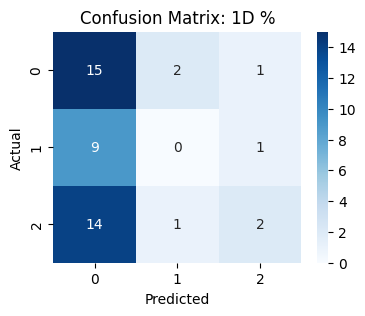

----------------------------------------
Results for 1W %:
Accuracy: 0.5111
F1 Score: 0.4218


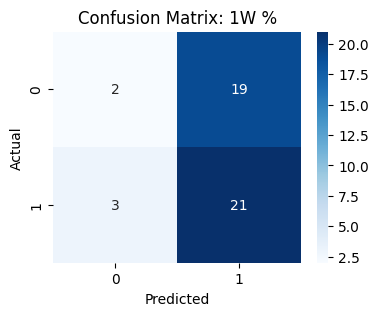

----------------------------------------
Results for 1M %:
Accuracy: 0.5333
F1 Score: 0.5319


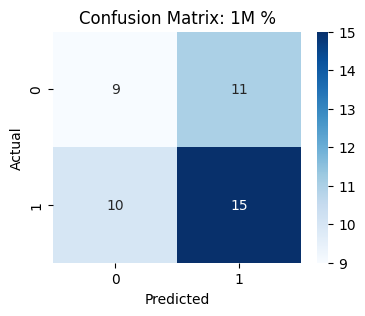

----------------------------------------
Results for 6M %:
Accuracy: 0.5610
F1 Score: 0.5547


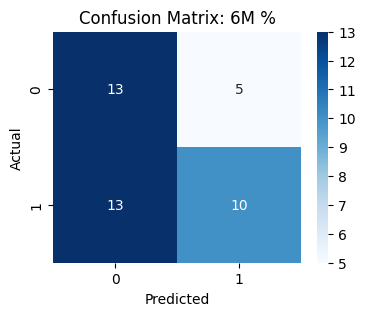

----------------------------------------
Results for 1Y %:
Accuracy: 0.4872
F1 Score: 0.4576


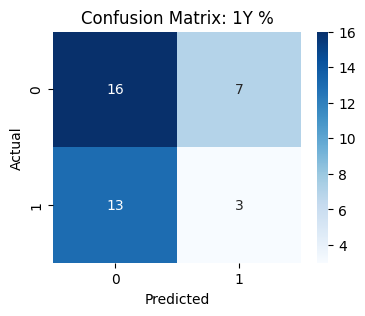

----------------------------------------


In [ ]:
for name, y_true, y_pred_ in zip(
    ['1D %', '1W %', '1M %', '6M %', '1Y %'],
    [y_1d_test, y_1w_test, y_1m_test, y_6m_test, y_1y_test],
    [rf_1d.predict(X_1d_test), rf_1w.predict(X_1w_test), rf_1m.predict(X_1m_test), rf_6m.predict(X_6m_test), rf_1y.predict(X_1y_test)]
):
    acc = accuracy_score(y_true, y_pred_)
    f1 = f1_score(y_true, y_pred_, average='weighted')
    cm = confusion_matrix(y_true, y_pred_)
    print(f"Results for {name}:")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    print('-' * 40)

#### Catboost + CalibratedSearchCV

CatBoost Results for 1D %:
Accuracy: 0.5400
F1 Score: 0.5175


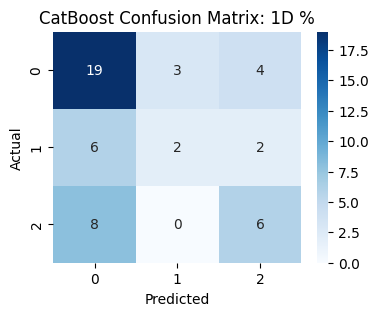

----------------------------------------
CatBoost Results for 1W %:
Accuracy: 0.6400
F1 Score: 0.6297


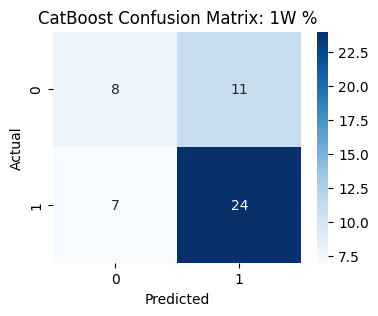

----------------------------------------
CatBoost Results for 1M %:
Accuracy: 0.5682
F1 Score: 0.5603


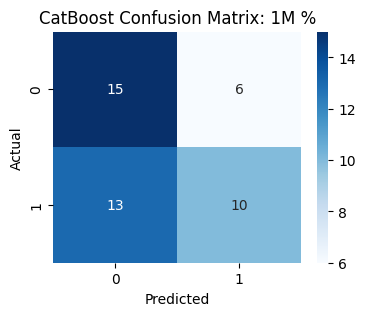

----------------------------------------
CatBoost Results for 6M %:
Accuracy: 0.7045
F1 Score: 0.7038


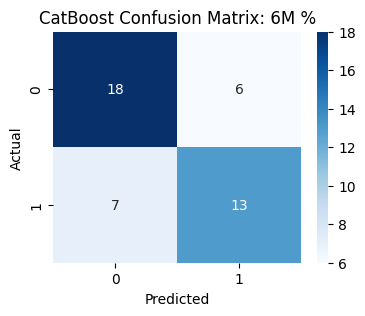

----------------------------------------
CatBoost Results for 1Y %:
Accuracy: 0.7727
F1 Score: 0.7654


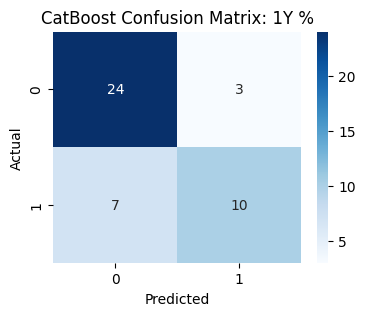

----------------------------------------


In [ ]:
# param_grid = {
#     'depth': [4, 6, 8, 10],
#     'learning_rate': [0.005, 0.01, 0.05, 0.1],
#     'iterations': [100, 200, 300]
# }

# def fit_calibrated_catboost(X_train, y_train):
#     base_model = CatBoostClassifier(verbose=0, random_state=42)
#     grid = GridSearchCV(base_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
#     grid.fit(X_train, y_train)
#     best_model = grid.best_estimator_
#     calibrated = CalibratedClassifierCV(best_model, method='sigmoid', cv=3)
#     calibrated.fit(X_train, y_train)
#     return calibrated

# cat_1d = fit_calibrated_catboost(X_1d_train_sm, y_1d_train_sm)
# cat_1w = fit_calibrated_catboost(X_1w_train_sm, y_1w_train_sm)
# cat_1m = fit_calibrated_catboost(X_1m_train_sm, y_1m_train_sm)
# cat_6m = fit_calibrated_catboost(X_6m_train_sm, y_6m_train_sm)
# cat_1y = fit_calibrated_catboost(X_1y_train_sm, y_1y_train_sm)

# for name, y_true, model, X_test in zip(
#     ['1D %', '1W %', '1M %', '6M %', '1Y %'],
#     [y_1d_test, y_1w_test, y_1m_test, y_6m_test, y_1y_test],
#     [cat_1d, cat_1w, cat_1m, cat_6m, cat_1y],
#     [X_1d_test, X_1w_test, X_1m_test, X_6m_test, X_1y_test]
# ):
#     y_pred_ = model.predict(X_test)
#     acc = accuracy_score(y_true, y_pred_)
#     f1 = f1_score(y_true, y_pred_, average='weighted')
#     cm = confusion_matrix(y_true, y_pred_)
#     print(f"CatBoost Results for {name}:")
#     print(f"Accuracy: {acc:.4f}")
#     print(f"F1 Score: {f1:.4f}")
#     plt.figure(figsize=(4, 3))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
#     plt.title(f'CatBoost Confusion Matrix: {name}')
#     plt.xlabel('Predicted')
#     plt.ylabel('Actual')
#     plt.show()
#     print('-' * 40)